## 1. Getting Started: Data Loading and Initial Exploration 🕵️‍♂️

First, I needed to get a handle on the data. I started by importing the essential Python libraries for this analysis: **pandas** for data manipulation, **NumPy** for numerical operations, and **Matplotlib/Seaborn** for visualizations.

Then, I loaded the massive 11.1 million-row dataset. My initial exploration using `.head()`, `.shape`, and `.describe()` was crucial. This first step gave me a bird's-eye view of the dataset, helping me establish its size and get a sense of the data's range. It immediately flagged two key things:
1. A `DtypeWarning`, telling me some columns had mixed data types that I'd need to fix.
2. The `AMOUNT` column had a huge range, including negative values, which suggested the presence of refunds or corrections.

## 2. The Foundation: Data Cleaning and Quality Assessment 🧹

The initial exploration revealed some significant data quality issues that I had to address to ensure the analysis was accurate. Using `.isnull().sum()`, I found that many columns like `PROJECT` and `ACTIVITY` were mostly empty, making them unsuitable for most of my analysis.

My key cleaning steps were:
* **Handling Negative Values:** I confirmed the `AMOUNT` column had negative values. Since my focus was on expenditure, I created a new, clean dataset (`delaware_checkbook_positive_amounts.csv`) that contains only the positive transactions.
* **Investigating Nulls:** I looked into the single row where `VENDOR` was null. I discovered it was a "PAYROLL" transaction, which logically explains the absence of an external vendor.
* **Identifying Duplicates:** My check for duplicates with `.duplicated().sum()` revealed **288,732 identical rows**. This was a major finding, as these could heavily skew any summary statistics or models.
* **Creating a Final Clean Dataset:** To simplify the core analysis, I created a final dataset (`delaware_checkbook_no_missing.csv`) by selecting only the columns with zero missing values. This gave me a reliable 15-column DataFrame to work with for pattern detection.
## 3. The Detective Work: Anomaly and Pattern Detection 📊

Once the data was clean, I started looking for unusual patterns that could point to inefficiency, waste, or potential fraud. I used a few different techniques:

* **Holiday Spending Analysis:** Payments on holidays can be a red flag. Using the `holidays` library, I found and flagged **29,468 transactions that occurred on U.S. holidays**. I then took it a step further to find the top 10 vendors by total spending on Delaware state holidays.
* **Z-Score Anomaly Detection:** To find statistical outliers in the massive dataset, I calculated the **Z-score** for transaction amounts. I used the log-transformed amount (`z_log_overall`) because financial data is often skewed, and this method helps flag transactions that are unusually high or low compared to the norm.
* **Duplicate Check Number Analysis:** To distinguish legitimate batch payments from potentially fraudulent duplicate checks, I grouped transactions by `CHECK_NUMBER`. This quickly confirmed that "PAYROLL" was the most frequent, which makes sense for batch salary payments.

## 4. Generating Insights: Vendor and Spending Analysis 📈

With the data clean and anomalies flagged, I moved on to generating actionable business insights. My goal here was to understand the relationships between spending categories (`ACCOUNT_DESCR`) and the vendors being paid.

By grouping the data, I was able to determine:
* The **top vendors by the number of transactions** for each spending category.
* The **top vendors by the total dollar amount spent** for each category.

This analysis provides direct answers to critical procurement questions like, "Who are we paying most often for IT services?" or "Who is our highest-paid vendor for construction?". These insights are the foundation for smarter contract negotiations and identifying opportunities for vendor consolidation.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Hen_Hacks_Hackathon/Delaware_Checkbook_Expenditure_Details_20250813.csv')

/tmp/ipython-input-4113514739.py:1: DtypeWarning: Columns (11,12,14,17,18,19,20,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Hen_Hacks_Hackathon/Delaware_Checkbook_Expenditure_Details_20250813.csv')


In [ ]:
df.head()

,FISCAL YEAR,FISCAL PERIOD,DEPARTMENT,DIVISION,VENDOR,BUDGET_REF,FUND_TYPE,FUND,FUND_DESCR,DEPTID,...,SCH_CODE_DESCR,PC_BU,PC_BU_DESCR,PROJECT,PROJECT_DESCR,ACTIVITY,ACTIVITY_DESCR,CHECK_NUMBER,CHECK_DATE,AMOUNT
0,2026,1,DEPT OF EDUCATION,POLYTECH SCHOOL DISTRICT,10-SPEC,2026.0,SPECIAL,270,Local Funds,953900,...,Polytech High School,NaN,NaN,NaN,NaN,NaN,NaN,0000437195,07/09/2025,717.00
1,2026,1,OTHER ELECTIVE OFFICES,REFUNDS & GRANTS,100 BLACK MEN OF DELAWARE,2026.0,GENERAL,100,General Fund,120504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000563605,07/30/2025,5000.00
2,2026,1,DEPT OF EDUCATION,COLONIAL SCHOOL DISTRICT,11 READS WAY LLC,2026.0,SPECIAL,270,Local Funds,953400,...,To Be Allocated,NaN,NaN,NaN,NaN,NaN,NaN,0000555106,07/10/2025,14685.00
3,2026,1,DEPARTMENT OF HUMAN RESOURCES,OFFICE OF THE SECRETARY,11 READS WAY LLC,2026.0,GENERAL,100,General Fund,160101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000557538,07/16/2025,29923.46
4,2026,1,DEPT OF TECHNOLOGY & INFORMATI,CHIEF SECURITY OFFICER,1111 SYSTEMS INC,2025.0,GENERAL,100,General Fund,110201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000557002,07/15/2025,19085.90


In [ ]:
df.shape

(11191357, 30)

In [ ]:
df['VENDOR'].nunique()

81985

In [ ]:
df['AMOUNT'].describe()

,AMOUNT
count,1.119136e+07
mean,5.161864e+03
std,2.960209e+05
min,-2.000000e+07
25%,2.280000e+01
50%,1.465400e+02
75%,9.537200e+02
max,2.091703e+08


In [ ]:
df['FUND_DESCR'].unique()

array(['Local Funds', 'General Fund', 'Federal Funds', 'Capital Projects',
       'Academia Antonia Alonso Local', 'Newark General',
       'Family Foundations Local', 'DelDOT Operational', 'MOT General',
       'Odyssey General', 'Las Americas ASPIRA Local',
       'Delaware State University', 'DelDOT Capital',
       'Federal DelDOT Capital', 'Sussex Academy General', 'Newark Local',
       'Freire Charter School General', 'Lottery',
       'Academy Of Dover General', '1st State Military Acad GF',
       'Other Expendable Trust', 'Pension Trust Funds',
       'Academia Antonia Alonso Genera', 'Charter School Wilm General',
       'DelDOT General Fund', 'Gateway Lab Local',
       '1st State Military Acad Local', 'Las Americas ASPIRA Federal',
       '1stState Montessori Acad Gener', 'Odyssey Local',
       'Campus Community General', 'Sussex Montessori Schl General',
       'Custodial - Pass Thru', 'Thomas A Edison General',
       'Providence Creek General', 'Las Americas ASPIRA Gen

In [ ]:
df['ACCOUNT_DESCR'].unique()

array(['EQUIPMENT SUPP & MAINT MAT', 'GRANTS IN AID',
       'BUILDINGS - OFFICE SPACE', 'IT SECURITY SERVICES',
       'CAFETERIA EQUIP', 'CAFETERIA SUPPLIES', 'INSTRUCTIONAL SUPPLIES',
       'CONSTRUCTION/BUILDING SERVICES', 'PUBLIC UTILITIES',
       'WELFR & SIMLR ASST GRANTS', 'FOOD', 'BUILDING/GROUNDS REPAIR',
       'BUILDING MATERIALS', 'MAINTENANCE', 'SANITARY SERVICES',
       'OTHER PROFESSIONAL SERVICE', 'TEMPORARY EMPLOYMENT SERVICE',
       'EMPLOYEE UNION DUES', 'EXPRESS CHARGES', 'ATHLETIC SERVICES',
       'CLIENT ASSISTANCE', 'MEDICAL SERVICES', 'VEHICLE MATERIALS',
       'TELECOMMUNICATION', 'RENT SUPP PAYMENT',
       'PERMIT/CERTS/TRANS/MISFEE/LICS', 'PROMOTIONAL SUPPLIES',
       'RELATED SERVICES', 'PRINTING & BINDING', 'FREIGHT',
       'MISCELLANEOUS EXPENSES', 'ADVERTISING', 'CLOTHING & INCIDENTALS',
       'CUSTODIAL SVC OFC/BLDG/GRD', 'INSTR SUPPORT SERVICES',
       'CLOUD SERVICES', 'INSTRUCTIONAL SERVICES', 'AID TO DISABLED',
       'CENTRAL ADMIN SERVI

In [ ]:
df.isnull().sum()

,0
FISCAL YEAR,0
FISCAL PERIOD,0
DEPARTMENT,0
DIVISION,0
VENDOR,1
BUDGET_REF,696620
FUND_TYPE,0
FUND,0
FUND_DESCR,0
DEPTID,0


In [ ]:
df['VENDOR'].isnull().sum()

np.int64(1)

In [ ]:
vendor_null_rows = df[df['VENDOR'].isnull()]
vendor_null_rows.head()

,FISCAL YEAR,FISCAL PERIOD,DEPARTMENT,DIVISION,VENDOR,BUDGET_REF,FUND_TYPE,FUND,FUND_DESCR,DEPTID,...,SCH_CODE_DESCR,PC_BU,PC_BU_DESCR,PROJECT,PROJECT_DESCR,ACTIVITY,ACTIVITY_DESCR,CHECK_NUMBER,CHECK_DATE,AMOUNT
3076309,2023,5,DEPT OF EDUCATION,CAPE HENLOPEN SCHOOL DISTRICT,NaN,2022.0,SPECIAL,270,Local Funds,951700,...,Cape Henlopen Central Office,NaN,NaN,NaN,NaN,NaN,NaN,PAYROLL,11/17/2022,-11563.9


In [ ]:
df['AMOUNT'] = pd.to_numeric(df['AMOUNT'], errors='coerce')
positive_count = (df['AMOUNT'] > 0).sum()
negative_count = (df['AMOUNT'] < 0).sum()
zero_count = (df['AMOUNT'] == 0).sum()

print(f"Positive amounts: {positive_count}")
print(f"Negative amounts: {negative_count}")
print(f"Zero amounts: {zero_count}")

Positive amounts: 11094990
Negative amounts: 95808
Zero amounts: 559


In [ ]:
df['AMOUNT'] = pd.to_numeric(df['AMOUNT'], errors='coerce')

df_positive = df[df['AMOUNT'] > 0].copy()

df_positive.to_csv('delaware_checkbook_positive_amounts.csv', index=False)

print(f"Saved cleaned dataset with {df_positive.shape[0]} rows to delaware_checkbook_positive_amounts.csv")


Saved cleaned dataset with 11094990 rows to delaware_checkbook_positive_amounts.csv


In [ ]:
!pip install holidays

In [ ]:
df['CHECK_DATE'] = pd.to_datetime(df['CHECK_DATE'], errors='coerce')


In [ ]:
us_holidays = holidays.US(years=range(df['CHECK_DATE'].dt.year.min(),
                                      df['CHECK_DATE'].dt.year.max()+1))

In [ ]:
# Flag transactions on U.S. holidays
df['is_us_holiday'] = df['CHECK_DATE'].isin(us_holidays)

# Filter only holiday transactions
holiday_transactions = df[df['is_us_holiday']]

print(f"Number of transactions on U.S. holidays: {holiday_transactions.shape[0]}")
holiday_transactions[['CHECK_DATE', 'VENDOR', 'AMOUNT']]

/tmp/ipython-input-3961029139.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_us_holiday'] = df['CHECK_DATE'].isin(us_holidays)


Number of transactions on U.S. holidays: 29468


,CHECK_DATE,VENDOR,AMOUNT
1724,2025-07-04,AETNA,798262.40
1725,2025-07-04,AETNA,3740836.59
1726,2025-07-04,AETNA,345654.00
1728,2025-07-04,AETNA,148155.36
5453,2025-07-04,BANC OF AMERICA PUBLIC CAPITAL,3029.98
...,...,...,...
11130782,2020-10-12,OTHER EMPLOYMENT COSTS BENEFITS,2173.29
11131745,2020-10-12,OTHER EMPLOYMENT COSTS BENEFITS,92.22
11132782,2020-10-12,OTHER EMPLOYMENT COSTS BENEFITS,34502.83
11133273,2020-10-12,OTHER EMPLOYMENT COSTS BENEFITS,368.87


In [ ]:
de_holidays = holidays.CountryHoliday('US', state='DE',
                                      years=range(df['CHECK_DATE'].dt.year.min(),
                                                  df['CHECK_DATE'].dt.year.max()+1))
df['CHECK_DATE'] = pd.to_datetime(df['CHECK_DATE'], errors='coerce')

# Flag Delaware holiday transactions
df['is_de_holiday'] = df['CHECK_DATE'].isin(pd.to_datetime(list(de_holidays.keys())))

In [ ]:
# Filter Delaware holiday transactions
de_holiday_txns = df[df['is_de_holiday']].copy()

# Convert amount to numeric
de_holiday_txns['AMOUNT'] = pd.to_numeric(de_holiday_txns['AMOUNT'], errors='coerce')

# Group by vendor and sum
vendor_spend = (de_holiday_txns.groupby('VENDOR')['AMOUNT']
                .sum()
                .reset_index()
                .sort_values('AMOUNT', ascending=False))

vendor_spend.head(10)


,VENDOR,AMOUNT
525,HIGHMARK HEALTH SERVICES,17199784.84
266,CVS PHARMACY INC,13659133.98
999,SILVERSCRIPT INSURANCE COMPANY,10089037.58
334,DHSS CHILD CARE DIRECT DEPOSIT ACCOUNT,6673329.53
27,AETNA,5032908.35
251,CONNER STRONG COMPANIES INC,4755275.20
198,CENTURION OF DELAWARE LLC,1730071.84
508,HARRINGTON RACEWAY,1687938.64
195,CDW GOVERNMENT INC,1430243.56
312,DELAWARE RACING ASSN,1306235.56


In [ ]:
vendor_spend['VENDOR'].unique()

array(['HIGHMARK HEALTH SERVICES', 'CVS PHARMACY INC',
       'SILVERSCRIPT INSURANCE COMPANY', ...,
       'DHSS DIV OF STATE SERV CTRS', 'RCCSD TRANSPORATION',
       'OMB ADMINISTRATION'], dtype=object)

In [ ]:
missing_vendor_rows = df[df['VENDOR'].isna()]
print("Number of transactions with missing vendor:", missing_vendor_rows.shape[0])
missing_vendor_rows[['CHECK_DATE', 'AMOUNT', 'DEPARTMENT','DIVISION','ACCOUNT_DESCR','FUND','FUND_DESCR']].head()

Number of transactions with missing vendor: 1


,CHECK_DATE,AMOUNT,DEPARTMENT,DIVISION,ACCOUNT_DESCR,FUND,FUND_DESCR
3076309,2022-11-17,-11563.9,DEPT OF EDUCATION,CAPE HENLOPEN SCHOOL DISTRICT,TRANSFER OUT,270,Local Funds


In [ ]:
df['FUND'].unique()

array([270, 100, 225, 300,   5, 189,  80, 101, 188, 186,  69, 910, 301,
       302, 177,  89, 112, 660, 185, 107, 890, 845, 105, 170, 102,  92,
         7, 569, 106,  86, 174, 114, 880, 176, 187, 169, 171,  72,  87,
       115, 224,  77,  85,   6,   4,  71, 589,  74, 574,  76, 182, 576,
        82, 192, 789, 179,  14, 777, 586, 570, 104, 111, 172, 855,  70,
        88, 577, 180, 504, 582, 505, 512, 587,  11, 580, 514, 572, 507,
       506, 511, 571, 650, 585, 843, 844, 705,  15, 588, 592, 579, 515,
        79, 704, 774,  12, 707, 103, 479, 776, 772, 714, 785, 780, 706,
       779, 712, 787, 711, 782, 792, 786, 769, 770, 788, 771])

In [ ]:
negative_count = (df['AMOUNT'] < 0).sum()

print(f"Number of transactions with AMOUNT < 0: {negative_count}")

Number of transactions with AMOUNT < 0: 95808


In [ ]:
negative_transactions = df[df['AMOUNT'] < 0]
negative_transactions.shape

(95808, 32)

In [ ]:
total_negative_amount = df.loc[df['AMOUNT'] < 0, 'AMOUNT'].sum()
print(f"Total of negative transactions: {total_negative_amount}")

Total of negative transactions: -398718965.33


In [ ]:
positive_count = (df['AMOUNT'] > 0).sum()

print(f"Number of transactions with AMOUNT > 0: {positive_count}")

Number of transactions with AMOUNT > 0: 11094990


In [ ]:
total_positive_count = df.loc[df['AMOUNT'] > 0, 'AMOUNT'].sum()
print(f"Total of positive transactions: {total_positive_count}")

Total of positive transactions: 58166984528.62003


In [ ]:
duplicate_count = df.duplicated().sum()
print(f"Number of exact duplicate rows: {duplicate_count}")

Number of exact duplicate rows: 288732


In [ ]:
duplicates = df[df.duplicated()]
duplicates.head()

,FISCAL YEAR,FISCAL PERIOD,DEPARTMENT,DIVISION,VENDOR,BUDGET_REF,FUND_TYPE,FUND,FUND_DESCR,DEPTID,...,SCH_CODE_DESCR,PC_BU,PC_BU_DESCR,PROJECT,PROJECT_DESCR,ACTIVITY,ACTIVITY_DESCR,CHECK_NUMBER,CHECK_DATE,AMOUNT
36,2026,1,LEGAL,DEPARTMENT OF JUSTICE,13 THE CIRCLE LLC,2026.0,GENERAL,100,General Fund,150101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000562798,07/29/2025,11016.71
38,2026,1,LEGAL,DEPARTMENT OF JUSTICE,13 THE CIRCLE LLC,2026.0,GENERAL,100,General Fund,150101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000562798,07/29/2025,562.50
113,2026,1,DEPT OF NATRL RES AND ENV CONT,PARKS AND RECREATION,1ST STATE PEST AND HOME SERVICES LLC,2025.0,SPECIAL,100,General Fund,400302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000558126,07/17/2025,100.00
114,2026,1,DEPT OF NATRL RES AND ENV CONT,PARKS AND RECREATION,1ST STATE PEST AND HOME SERVICES LLC,2025.0,SPECIAL,100,General Fund,400302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000558126,07/17/2025,100.00
120,2026,1,DEPT OF SAFETY & HOMELAND SEC,PATROL,1ST STATE PEST AND HOME SERVICES LLC,2025.0,GENERAL,100,General Fund,450603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000562338,07/28/2025,20.00


In [ ]:
for col in df.columns:
    num_unique = df[col].nunique(dropna=False)
    num_total = len(df[col])
    num_duplicates = num_total - num_unique
    print(f"{col}: {num_duplicates} duplicate values")


FISCAL YEAR: 11191352 duplicate values
FISCAL PERIOD: 11191345 duplicate values
DEPARTMENT: 11191333 duplicate values
DIVISION: 11191025 duplicate values
VENDOR: 11109371 duplicate values
BUDGET_REF: 11191329 duplicate values
FUND_TYPE: 11191353 duplicate values
FUND: 11191242 duplicate values
FUND_DESCR: 11191242 duplicate values
DEPTID: 11191018 duplicate values
DEPTID_DESCR: 11191025 duplicate values
OP_UNIT: 11187516 duplicate values
OP_UNIT_DESCR: 11188964 duplicate values
APPROP: 11188061 duplicate values
APPROP_DESCR: 11188326 duplicate values
ACCOUNT: 11190835 duplicate values
ACCOUNT_DESCR: 11190839 duplicate values
PROGRAM: 11188707 duplicate values
PROGRAM_DESCR: 11188882 duplicate values
SCH_CODE: 11191042 duplicate values
SCH_CODE_DESCR: 11191053 duplicate values
PC_BU: 11191317 duplicate values
PC_BU_DESCR: 11191317 duplicate values
PROJECT: 11177857 duplicate values
PROJECT_DESCR: 11181748 duplicate values
ACTIVITY: 11190706 duplicate values
ACTIVITY_DESCR: 11190720 dupl

In [ ]:
duplicate_cols = [col for col in df.columns if df[col].nunique(dropna=False) < len(df)]
print("Columns with duplicate values:", duplicate_cols)

Columns with duplicate values: ['FISCAL YEAR', 'FISCAL PERIOD', 'DEPARTMENT', 'DIVISION', 'VENDOR', 'BUDGET_REF', 'FUND_TYPE', 'FUND', 'FUND_DESCR', 'DEPTID', 'DEPTID_DESCR', 'OP_UNIT', 'OP_UNIT_DESCR', 'APPROP', 'APPROP_DESCR', 'ACCOUNT', 'ACCOUNT_DESCR', 'PROGRAM', 'PROGRAM_DESCR', 'SCH_CODE', 'SCH_CODE_DESCR', 'PC_BU', 'PC_BU_DESCR', 'PROJECT', 'PROJECT_DESCR', 'ACTIVITY', 'ACTIVITY_DESCR', 'CHECK_NUMBER', 'CHECK_DATE', 'AMOUNT']


In [ ]:
dup_percent = ((len(df) - df.nunique(dropna=False)) / len(df) * 100).round(2)
dup_percent[dup_percent > 0]

,0
FISCAL YEAR,100.00
FISCAL PERIOD,100.00
DEPARTMENT,100.00
DIVISION,100.00
VENDOR,99.27
BUDGET_REF,100.00
FUND_TYPE,100.00
FUND,100.00
FUND_DESCR,100.00
DEPTID,100.00


In [ ]:
df['ACCOUNT_DESCR'].unique()

array(['EQUIPMENT SUPP & MAINT MAT', 'GRANTS IN AID',
       'BUILDINGS - OFFICE SPACE', 'IT SECURITY SERVICES',
       'CAFETERIA EQUIP', 'CAFETERIA SUPPLIES', 'INSTRUCTIONAL SUPPLIES',
       'CONSTRUCTION/BUILDING SERVICES', 'PUBLIC UTILITIES',
       'WELFR & SIMLR ASST GRANTS', 'FOOD', 'BUILDING/GROUNDS REPAIR',
       'BUILDING MATERIALS', 'MAINTENANCE', 'SANITARY SERVICES',
       'OTHER PROFESSIONAL SERVICE', 'TEMPORARY EMPLOYMENT SERVICE',
       'EMPLOYEE UNION DUES', 'EXPRESS CHARGES', 'ATHLETIC SERVICES',
       'CLIENT ASSISTANCE', 'MEDICAL SERVICES', 'VEHICLE MATERIALS',
       'TELECOMMUNICATION', 'RENT SUPP PAYMENT',
       'PERMIT/CERTS/TRANS/MISFEE/LICS', 'PROMOTIONAL SUPPLIES',
       'RELATED SERVICES', 'PRINTING & BINDING', 'FREIGHT',
       'MISCELLANEOUS EXPENSES', 'ADVERTISING', 'CLOTHING & INCIDENTALS',
       'CUSTODIAL SVC OFC/BLDG/GRD', 'INSTR SUPPORT SERVICES',
       'CLOUD SERVICES', 'INSTRUCTIONAL SERVICES', 'AID TO DISABLED',
       'CENTRAL ADMIN SERVI

In [ ]:
df['ACCOUNT_DESCR'] = df['ACCOUNT_DESCR'].astype(str).str.strip().str.upper()
df['VENDOR'] = df['VENDOR'].astype(str).str.strip().str.upper()

top_vendors_per_account = (
    df.groupby(['ACCOUNT_DESCR', 'VENDOR'])
    .size()
    .reset_index(name='transaction_count')
    .sort_values(['ACCOUNT_DESCR', 'transaction_count'], ascending=[True, False])
)

(141285, 3)

In [ ]:
top_vendors_per_account.head(10)

,ACCOUNT_DESCR,VENDOR,transaction_count
0,ABANDONED PROPERTY,ABANDONED PROPERTY,252
1,ACA PENALTY,OTHER EMPLOYMENT COSTS BENEFITS,46
2,ACADEMIC EXCELLENCE,EMPLOYEE COMPENSATION,23127
4,ADALEIGH LEE SOLES INCNTVE PGM,DREXEL UNIVERSITY,11
3,ADALEIGH LEE SOLES INCNTVE PGM,CLARION UNIVERSITY OF PA,8
12,ADALEIGH LEE SOLES INCNTVE PGM,UNIVERSITY OF DENVER,6
13,ADALEIGH LEE SOLES INCNTVE PGM,UNIVERSITY OF SOUTH FLORIDA,5
5,ADALEIGH LEE SOLES INCNTVE PGM,FLORIDA STATE UNIV,4
9,ADALEIGH LEE SOLES INCNTVE PGM,SAN JOSE STATE UNIVERSITY,4
11,ADALEIGH LEE SOLES INCNTVE PGM,UNIV OF SOUTHERN CALIFORNIA,4


In [ ]:
top_vendor_each_account = (
    top_vendors_per_account.groupby('ACCOUNT_DESCR').head(1)
    .reset_index(drop=True)
)

top_vendor_each_account

,ACCOUNT_DESCR,VENDOR,transaction_count
0,ABANDONED PROPERTY,ABANDONED PROPERTY,252
1,ACA PENALTY,OTHER EMPLOYMENT COSTS BENEFITS,46
2,ACADEMIC EXCELLENCE,EMPLOYEE COMPENSATION,23127
3,ADALEIGH LEE SOLES INCNTVE PGM,DREXEL UNIVERSITY,11
4,ADMIN ASSISTANTS,EMPLOYEE COMPENSATION,2508
...,...,...,...
513,WELFR & SIMLR ASST GRANTS,HERSHA HOSPITALITY MANAGEMENT,1448
514,WITHHOLDING TAX,INES HUNGRIA,1
515,WOODBRIDGE SCH DISTFLEX CREDIT,DELAWARE STATE HOUSING AUTHORITY,1
516,WORKER'S COMP,INSURANCE COVERAGE OFFICE OF M&B,158


In [ ]:
vendor_amount_per_account = (
    df.groupby(['ACCOUNT_DESCR', 'VENDOR'])['AMOUNT']
    .sum()
    .reset_index()
    .sort_values(['ACCOUNT_DESCR', 'AMOUNT'], ascending=[True, False])
)

vendor_amount_per_account.head(20)


,ACCOUNT_DESCR,VENDOR,AMOUNT
0,ABANDONED PROPERTY,ABANDONED PROPERTY,5492659.42
1,ACA PENALTY,OTHER EMPLOYMENT COSTS BENEFITS,78312.50
2,ACADEMIC EXCELLENCE,EMPLOYEE COMPENSATION,79329279.56
4,ADALEIGH LEE SOLES INCNTVE PGM,DREXEL UNIVERSITY,87035.40
11,ADALEIGH LEE SOLES INCNTVE PGM,UNIV OF SOUTHERN CALIFORNIA,48918.99
12,ADALEIGH LEE SOLES INCNTVE PGM,UNIVERSITY OF DENVER,32963.29
3,ADALEIGH LEE SOLES INCNTVE PGM,CLARION UNIVERSITY OF PA,30167.83
7,ADALEIGH LEE SOLES INCNTVE PGM,KENT STATE UNIV,22811.50
13,ADALEIGH LEE SOLES INCNTVE PGM,UNIVERSITY OF SOUTH FLORIDA,19369.59
14,ADALEIGH LEE SOLES INCNTVE PGM,UNIVERSITY OF WISCONSIN,17040.16


In [ ]:
pdf = pd.read_csv('/content/delaware_checkbook_positive_amounts.csv')

/tmp/ipython-input-3566660653.py:1: DtypeWarning: Columns (11,12,14,17,18,19,20,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  pdf = pd.read_csv('/content/delaware_checkbook_positive_amounts.csv')


In [ ]:
pdf.head()

,FISCAL YEAR,FISCAL PERIOD,DEPARTMENT,DIVISION,VENDOR,BUDGET_REF,FUND_TYPE,FUND,FUND_DESCR,DEPTID,...,SCH_CODE_DESCR,PC_BU,PC_BU_DESCR,PROJECT,PROJECT_DESCR,ACTIVITY,ACTIVITY_DESCR,CHECK_NUMBER,CHECK_DATE,AMOUNT
0,2026,1,DEPT OF EDUCATION,POLYTECH SCHOOL DISTRICT,10-SPEC,2026.0,SPECIAL,270,Local Funds,953900,...,Polytech High School,NaN,NaN,NaN,NaN,NaN,NaN,0000437195,07/09/2025,717.00
1,2026,1,OTHER ELECTIVE OFFICES,REFUNDS & GRANTS,100 BLACK MEN OF DELAWARE,2026.0,GENERAL,100,General Fund,120504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000563605,07/30/2025,5000.00
2,2026,1,DEPT OF EDUCATION,COLONIAL SCHOOL DISTRICT,11 READS WAY LLC,2026.0,SPECIAL,270,Local Funds,953400,...,To Be Allocated,NaN,NaN,NaN,NaN,NaN,NaN,0000555106,07/10/2025,14685.00
3,2026,1,DEPARTMENT OF HUMAN RESOURCES,OFFICE OF THE SECRETARY,11 READS WAY LLC,2026.0,GENERAL,100,General Fund,160101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000557538,07/16/2025,29923.46
4,2026,1,DEPT OF TECHNOLOGY & INFORMATI,CHIEF SECURITY OFFICER,1111 SYSTEMS INC,2025.0,GENERAL,100,General Fund,110201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000557002,07/15/2025,19085.90


In [ ]:
pdf.isnull().sum()

,0
FISCAL YEAR,0
FISCAL PERIOD,0
DEPARTMENT,0
DIVISION,0
VENDOR,0
BUDGET_REF,693356
FUND_TYPE,0
FUND,0
FUND_DESCR,0
DEPTID,0


In [ ]:
pdf.columns

Index(['FISCAL YEAR', 'FISCAL PERIOD', 'DEPARTMENT', 'DIVISION', 'VENDOR',
       'BUDGET_REF', 'FUND_TYPE', 'FUND', 'FUND_DESCR', 'DEPTID',
       'DEPTID_DESCR', 'OP_UNIT', 'OP_UNIT_DESCR', 'APPROP', 'APPROP_DESCR',
       'ACCOUNT', 'ACCOUNT_DESCR', 'PROGRAM', 'PROGRAM_DESCR', 'SCH_CODE',
       'SCH_CODE_DESCR', 'PC_BU', 'PC_BU_DESCR', 'PROJECT', 'PROJECT_DESCR',
       'ACTIVITY', 'ACTIVITY_DESCR', 'CHECK_NUMBER', 'CHECK_DATE', 'AMOUNT'],
      dtype='object')

In [ ]:
# Find columns with zero missing values
no_missing_cols = pdf.columns[pdf.isnull().sum() == 0]

# Create a new DataFrame with only those columns
df_no_missing = pdf[no_missing_cols].copy()

print("Columns with zero missing values:")
print(no_missing_cols.tolist())

# Save to CSV if needed
df_no_missing.to_csv("delaware_checkbook_no_missing.csv", index=False)
print(f"Saved dataset with {df_no_missing.shape[1]} columns and {df_no_missing.shape[0]} rows")


Columns with zero missing values:
['FISCAL YEAR', 'FISCAL PERIOD', 'DEPARTMENT', 'DIVISION', 'VENDOR', 'FUND_TYPE', 'FUND', 'FUND_DESCR', 'DEPTID', 'DEPTID_DESCR', 'ACCOUNT', 'ACCOUNT_DESCR', 'CHECK_NUMBER', 'CHECK_DATE', 'AMOUNT']
Saved dataset with 15 columns and 11094990 rows


In [ ]:
NMV_df = pd.read_csv('/content/drive/MyDrive/Hen_Hacks_Hackathon/delaware_checkbook_no_missing.csv')
NMV_df.head()

,FISCAL YEAR,FISCAL PERIOD,DEPARTMENT,DIVISION,VENDOR,FUND_TYPE,FUND,FUND_DESCR,DEPTID,DEPTID_DESCR,ACCOUNT,ACCOUNT_DESCR,CHECK_NUMBER,CHECK_DATE,AMOUNT
0,2026,1,DEPT OF EDUCATION,POLYTECH SCHOOL DISTRICT,10-SPEC,SPECIAL,270,Local Funds,953900,POLYTECH SCHOOL DISTRICT,56211,EQUIPMENT SUPP & MAINT MAT,0000437195,07/09/2025,717.00
1,2026,1,OTHER ELECTIVE OFFICES,REFUNDS & GRANTS,100 BLACK MEN OF DELAWARE,GENERAL,100,General Fund,120504,REFUNDS & GRANTS,55351,GRANTS IN AID,0000563605,07/30/2025,5000.00
2,2026,1,DEPT OF EDUCATION,COLONIAL SCHOOL DISTRICT,11 READS WAY LLC,SPECIAL,270,Local Funds,953400,COLONIAL SCHOOL DISTRICT,55402,BUILDINGS - OFFICE SPACE,0000555106,07/10/2025,14685.00
3,2026,1,DEPARTMENT OF HUMAN RESOURCES,OFFICE OF THE SECRETARY,11 READS WAY LLC,GENERAL,100,General Fund,160101,OFFICE OF THE SECRETARY,55402,BUILDINGS - OFFICE SPACE,0000557538,07/16/2025,29923.46
4,2026,1,DEPT OF TECHNOLOGY & INFORMATI,CHIEF SECURITY OFFICER,1111 SYSTEMS INC,GENERAL,100,General Fund,110201,CHIEF SECURITY OFFICER,55522,IT SECURITY SERVICES,0000557002,07/15/2025,19085.90


In [ ]:
NMV_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094990 entries, 0 to 11094989
Data columns (total 15 columns):
 #   Column         Dtype  
---  ------         -----  
 0   FISCAL YEAR    int64  
 1   FISCAL PERIOD  int64  
 2   DEPARTMENT     object 
 3   DIVISION       object 
 4   VENDOR         object 
 5   FUND_TYPE      object 
 6   FUND           int64  
 7   FUND_DESCR     object 
 8   DEPTID         int64  
 9   DEPTID_DESCR   object 
 10  ACCOUNT        int64  
 11  ACCOUNT_DESCR  object 
 12  CHECK_NUMBER   object 
 13  CHECK_DATE     object 
 14  AMOUNT         float64
dtypes: float64(1), int64(5), object(9)
memory usage: 1.2+ GB


In [ ]:
NMV_df.isnull().sum()

,0
FISCAL YEAR,0
FISCAL PERIOD,0
DEPARTMENT,0
DIVISION,0
VENDOR,0
FUND_TYPE,0
FUND,0
FUND_DESCR,0
DEPTID,0
DEPTID_DESCR,0


In [ ]:
NMV_df.head(1)

,FISCAL YEAR,FISCAL PERIOD,DEPARTMENT,DIVISION,VENDOR,FUND_TYPE,FUND,FUND_DESCR,DEPTID,DEPTID_DESCR,ACCOUNT,ACCOUNT_DESCR,CHECK_NUMBER,CHECK_DATE,AMOUNT
0,2026,1,DEPT OF EDUCATION,POLYTECH SCHOOL DISTRICT,10-SPEC,SPECIAL,270,Local Funds,953900,POLYTECH SCHOOL DISTRICT,56211,EQUIPMENT SUPP & MAINT MAT,0000437195,07/09/2025,717.0


In [ ]:
# 1) Stabilize skew: log1p(amount) (recommended for money)
NMV_df["amount_log"] = np.log1p(NMV_df["AMOUNT"].clip(lower=0))
# -------- Plain z on RAW amount --------
# Overall (sample std ddof=1)
mu_raw = NMV_df["AMOUNT"].mean()
sd_raw = NMV_df["AMOUNT"].std(ddof=1)
NMV_df["z_raw_overall"] = (NMV_df["AMOUNT"] - mu_raw) / sd_raw
# Per-group: (fiscal_year, department, vendor)
grp = ["FISCAL YEAR", "DEPARTMENT", "VENDOR"]
mu_raw_g = NMV_df.groupby(grp)["AMOUNT"].transform("mean")
sd_raw_g = NMV_df.groupby(grp)["AMOUNT"].transform(lambda s: s.std(ddof=1))
NMV_df["z_raw_by_group"] = (NMV_df["AMOUNT"] - mu_raw_g) / sd_raw_g.replace({0: np.nan})
NMV_df["z_raw_by_group"] = NMV_df["z_raw_by_group"].fillna(0)  # groups with no variance -> 0
# -------- Plain z on LOG amount (preferred) --------
# Overall
mu_log = NMV_df["amount_log"].mean()
sd_log = NMV_df["amount_log"].std(ddof=1)
NMV_df["z_log_overall"] = (NMV_df["amount_log"] - mu_log) / sd_log
# Per-group
mu_log_g = NMV_df.groupby(grp)["amount_log"].transform("mean")
sd_log_g = NMV_df.groupby(grp)["amount_log"].transform(lambda s: s.std(ddof=1))
NMV_df["z_log_by_group"] = (NMV_df["amount_log"] - mu_log_g) / sd_log_g.replace({0: np.nan})
NMV_df["z_log_by_group"] = NMV_df["z_log_by_group"].fillna(0)
if "row_id" not in NMV_df.columns:
    NMV_df = NMV_df.reset_index().rename(columns={"index": "row_id"}).set_index("row_id", drop=False)
# -------- Quick look: biggest per-group deviations on LOG z --------
preview_cols = ["FISCAL YEAR","DEPARTMENT","VENDOR","AMOUNT","z_log_overall"]
outliers = (NMV_df.assign(abs_z=np.abs(NMV_df["z_log_by_group"]))
              .sort_values("abs_z", ascending=False)
              [preview_cols])
print(outliers)

         FISCAL YEAR                   DEPARTMENT  \
row_id                                              
1113585         2024                DEPT OF LABOR   
7317946         2022                DEPT OF LABOR   
3811795         2023                DEPT OF LABOR   
3810609         2023                DEPT OF LABOR   
3809966         2023                DEPT OF LABOR   
...              ...                          ...   
1150271         2024  DEPT OF EDUCATION CONTINUED   
1150269         2024       OTHER ELECTIVE OFFICES   
1150268         2024       DEPT OF TRANSPORTATION   
1150284         2024  DEPT OF HEALTH & SOCIAL SVS   
5164738         2023            DEPT OF EDUCATION   

                                     VENDOR     AMOUNT  z_log_overall  
row_id                                                                 
1113585                 VERISMA SYSTEMS INC       7.75      -1.172218  
7317946                 VERISMA SYSTEMS INC       6.00      -1.262598  
3811795               

In [ ]:
# --- sanity: required columns ---
required = {"VENDOR", "ACCOUNT_DESCR", "z_log_overall"}
missing = required - set(NMV_df.columns)
if missing:
    raise KeyError(f"Missing columns in NMV_df: {missing}")
# --- filter: only transactions with z_log_overall < -1 ---
neg = NMV_df.loc[NMV_df["z_log_overall"] < -1].copy()
# --- (vendor, account_description) aggregation ---
# always produce count; add amount stats if 'amount' exists
grp_keys = ["VENDOR", "ACCOUNT_DESCR"]
agg_count = neg.groupby(grp_keys).size().reset_index(name="n_transactions")
if "AMOUNT" in neg.columns:
    amt_stats = (neg.groupby(grp_keys)["AMOUNT"]
                   .agg(total_amount="sum", n_transactions="size")
                   .reset_index())
    vendor_service_agg = agg_count.merge(amt_stats, on=grp_keys, how="left")
else:
    vendor_service_agg = agg_count
vendor_service_agg = vendor_service_agg.sort_values(
    ["n_transactions_x", "total_amount" if "total_amount" in vendor_service_agg.columns else "n_transactions_x"],
    ascending=False
).reset_index(drop=True)
print("Top 20 (vendor, service) with z_log_overall < -1:")
print(vendor_service_agg.head(300000))
# --- optional: list of services per vendor under the same filter ---
services_per_vendor = (neg.groupby("VENDOR")["ACCOUNT_DESCR"]
                         .apply(lambda s: sorted(pd.unique(s.astype(str).str.strip())) )
                         .reset_index(name="services_below_neg1"))
services_per_vendor["n_services"] = services_per_vendor["services_below_neg1"].str.len()
services_per_vendor = services_per_vendor.sort_values("n_services", ascending=False).reset_index(drop=True)
print("\nVendors with services where z_log_overall < -1 (top 20):")
print(services_per_vendor.head(30000))

Top 20 (vendor, service) with z_log_overall < -1:
                               VENDOR               ACCOUNT_DESCR  \
0     OTHER EMPLOYMENT COSTS BENEFITS   UNEMPLOYMENT INS BENEFITS   
1     OTHER EMPLOYMENT COSTS BENEFITS   EMPLOYER'S SHARE-MEDICARE   
2     OTHER EMPLOYMENT COSTS BENEFITS      WORKMEN'S COMPENSATION   
3      DELAWARE STATE EDUCATION ASSOC         EMPLOYEE UNION DUES   
4     OTHER EMPLOYMENT COSTS BENEFITS        GROUP LIFE INSURANCE   
...                               ...                         ...   
9990                     UPTODATE INC           COMPUTER SERVICES   
9991    VARSITY BRANDS HOLDING CO INC    STUDENT SUPPORT SUPPLIES   
9992              VERTIV SERVICES INC  OTHER PROFESSIONAL SERVICE   
9993                      WAYFAIR LLC     INSTITUTIONAL EQUIPMENT   
9994   WESLEY UNITED METHODIST CHURCH           CLIENT ASSISTANCE   

      n_transactions_x  total_amount  n_transactions_y  
0               669231    1956058.38            669231  
1      

In [ ]:
required = {"VENDOR", "ACCOUNT_DESCR", "z_log_overall"}
missing = required - set(NMV_df.columns)
if missing:
    raise KeyError(f"Missing columns in NMV_df: {missing}")

grp_keys = ["VENDOR", "ACCOUNT_DESCR"]

def summarize_transactions(df, condition_label):
    """Summarize vendors & services for a given condition."""
    agg_count = df.groupby(grp_keys).size().reset_index(name="n_transactions")
    # Amount stats if AMOUNT exists
    if "AMOUNT" in df.columns:
        amt_stats = (
            df.groupby(grp_keys)["AMOUNT"]
              .agg(total_amount="sum", n_transactions="size")
              .reset_index()
        )
        vendor_service_agg = agg_count.merge(amt_stats, on=grp_keys, how="left")
    else:
        vendor_service_agg = agg_count

    # Sort
    sort_cols = ["n_transactions_x", "total_amount"] if "total_amount" in vendor_service_agg.columns else ["n_transactions_x"]
    vendor_service_agg = vendor_service_agg.sort_values(sort_cols, ascending=False).reset_index(drop=True)

    print(f"\nTop (vendor, service) where {condition_label}:")
    print(vendor_service_agg.head(1000))

    # Services per vendor
    services_per_vendor = (
        df.groupby("VENDOR")["ACCOUNT_DESCR"]
          .apply(lambda s: sorted(pd.unique(s.astype(str).str.strip())))
          .reset_index(name="services_list")
    )
    services_per_vendor["n_services"] = services_per_vendor["services_list"].str.len()
    services_per_vendor = services_per_vendor.sort_values("n_services", ascending=False).reset_index(drop=True)

    print(f"\nVendors with services where {condition_label}:")
    print(services_per_vendor.head(1000))

    return vendor_service_agg, services_per_vendor

# --- Condition 1: z_log_overall < -1 ---
neg_pairs, neg_vendors = summarize_transactions(NMV_df.loc[NMV_df["z_log_overall"] < -1].copy(), "z_log_overall < -1")

# --- Condition 2: z_log_overall > 1.5 ---
pos_pairs, pos_vendors = summarize_transactions(NMV_df.loc[NMV_df["z_log_overall"] > 1.5].copy(), "z_log_overall > 1.5")

with pd.ExcelWriter("vendor_service_zscore_analysis.xlsx") as writer:
  neg_pairs.to_excel(writer, sheet_name="Top_pairs_lt_-1", index=False)
  neg_vendors.to_excel(writer, sheet_name="Vendors_lt_-1", index=False)
  pos_pairs.to_excel(writer, sheet_name="Top_pairs_gt_1.5", index=False)
  pos_vendors.to_excel(writer, sheet_name="Vendors_gt_1.5", index=False)


Top (vendor, service) where z_log_overall < -1:
                              VENDOR               ACCOUNT_DESCR  \
0    OTHER EMPLOYMENT COSTS BENEFITS   UNEMPLOYMENT INS BENEFITS   
1    OTHER EMPLOYMENT COSTS BENEFITS   EMPLOYER'S SHARE-MEDICARE   
2    OTHER EMPLOYMENT COSTS BENEFITS      WORKMEN'S COMPENSATION   
3     DELAWARE STATE EDUCATION ASSOC         EMPLOYEE UNION DUES   
4    OTHER EMPLOYMENT COSTS BENEFITS        GROUP LIFE INSURANCE   
..                               ...                         ...   
995        OMB MAIL/COURIER SERVICES           TELECOMMUNICATION   
996   DOCUVAULT SECURE SHREDDING LLC                    SECURITY   
997                 EXPRESS SERVICES  OTHER PROFESSIONAL SERVICE   
998      C2 IMAGING LLC  DBA VISUALZ          CAFETERIA SUPPLIES   
999                FISHER SCIENTIFIC                     FREIGHT   

     n_transactions_x  total_amount  n_transactions_y  
0              669231    1956058.38            669231  
1              201903 

In [ ]:
services_per_vendor.shape

(6378, 3)

In [ ]:
NMV_df.isnull().sum()

,0
row_id,0
FISCAL YEAR,0
FISCAL PERIOD,0
DEPARTMENT,0
DIVISION,0
VENDOR,0
FUND_TYPE,0
FUND,0
FUND_DESCR,0
DEPTID,0


In [ ]:
# Find duplicates by check number
dupes = (
    NMV_df.groupby(["CHECK_NUMBER", "DEPARTMENT", "DIVISION"], dropna=False)
          .agg(total_amount=("AMOUNT", "sum"),
               count=("CHECK_NUMBER", "size"))
          .reset_index()
)

# Keep only where the check number occurs more than once
dupes = dupes[dupes["count"] > 1]

# Sort to review easily
dupes = dupes.sort_values(["count", "total_amount"], ascending=False)

print("Duplicate check numbers with department, division, and total amount:")
print(dupes.head(50).to_string(index=False))


Duplicate check numbers with department, division, and total amount:
CHECK_NUMBER                     DEPARTMENT                       DIVISION  total_amount  count
     PAYROLL              DEPT OF EDUCATION RED CLAY CONSOLIDATED SCH DIST  993100491.36 651880
     PAYROLL              DEPT OF EDUCATION     BRANDYWINE SCHOOL DISTRICT  718108072.39 572203
     PAYROLL              DEPT OF EDUCATION      CHRISTINA SCHOOL DISTRICT  916859415.79 457948
     PAYROLL              DEPT OF EDUCATION  APPOQUINIMINK SCHOOL DISTRICT  707661459.97 331601
     PAYROLL              DEPT OF EDUCATION        CAPITAL SCHOOL DISTRICT  424796857.92 314949
     PAYROLL              DEPT OF EDUCATION       COLONIAL SCHOOL DISTRICT  632709825.94 288987
     PAYROLL    DEPT OF HEALTH & SOCIAL SVS               COMMUNITY HEALTH  179718366.31 276807
     PAYROLL              DEPT OF EDUCATION   INDIAN RIVER SCHOOL DISTRICT  620881715.99 246649
     PAYROLL              DEPT OF EDUCATION  CAPE HENLOPEN SCHOOL D

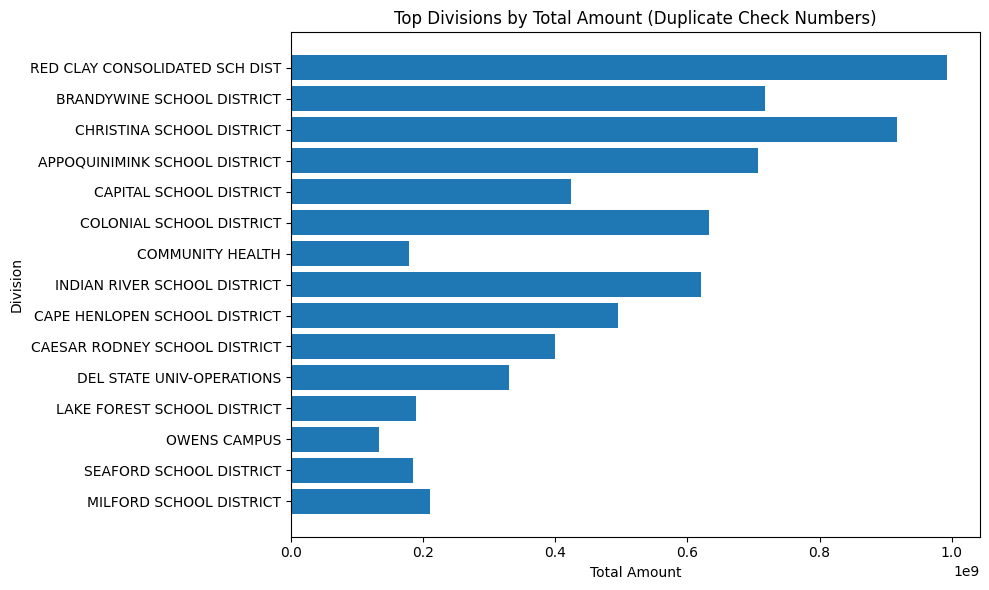

In [ ]:

import matplotlib.pyplot as plt

top_n = 15  # show top N rows
subset = dupes.head(top_n)

plt.figure(figsize=(10,6))
plt.barh(subset["DIVISION"], subset["total_amount"])
plt.xlabel("Total Amount")
plt.ylabel("Division")
plt.title("Top Divisions by Total Amount (Duplicate Check Numbers)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
NMV_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11094990 entries, 0 to 11094989
Data columns (total 21 columns):
 #   Column          Dtype  
---  ------          -----  
 0   row_id          int64  
 1   FISCAL YEAR     int64  
 2   FISCAL PERIOD   int64  
 3   DEPARTMENT      object 
 4   DIVISION        object 
 5   VENDOR          object 
 6   FUND_TYPE       object 
 7   FUND            int64  
 8   FUND_DESCR      object 
 9   DEPTID          int64  
 10  DEPTID_DESCR    object 
 11  ACCOUNT         int64  
 12  ACCOUNT_DESCR   object 
 13  CHECK_NUMBER    object 
 14  CHECK_DATE      object 
 15  AMOUNT          float64
 16  amount_log      float64
 17  z_raw_overall   float64
 18  z_raw_by_group  float64
 19  z_log_overall   float64
 20  z_log_by_group  float64
dtypes: float64(6), int64(6), object(9)
memory usage: 1.8+ GB


🚀 FAST DELAWARE EXPENDITURE ANALYSIS
📁 Loading dataset...
📊 Sampling 50,000 rows from 11,094,990 total rows
✅ Loaded 50,000 records
📊 Columns: ['FISCAL YEAR', 'FISCAL PERIOD', 'department', 'DIVISION', 'vendor', 'category', 'FUND', 'FUND_DESCR', 'DEPTID', 'DEPTID_DESCR', 'ACCOUNT', 'ACCOUNT_DESCR', 'CHECK_NUMBER', 'CHECK_DATE', 'amount']
💰 Total spending: $249,760,721.42

💰 Running price variance analysis...
💰 Starting fast price variance analysis...

✅ Found 405 consolidation opportunities
💰 Total potential savings: $266,097,252.89

🏆 TOP 5 OPPORTUNITIES:
1. Category: GENERAL
   💰 Savings: $142,139,864.76
   📊 Variation: 6265.8%
2. Category: SPECIAL
   💰 Savings: $46,255,985.64
   📊 Variation: 3008.2%
3. Category: FEDERAL
   💰 Savings: $42,674,649.92
   📊 Variation: 4179.8%
4. Category: CAPITAL
   💰 Savings: $18,689,679.70
   📊 Variation: 861.6%
5. Dept: DEPT OF HEALTH & SOCIAL SVS | Vendor: GAINWE
   💰 Savings: $6,485,258.35
   📊 Variation: 387.5%

🎯 Running clustering analysis...
🎯 

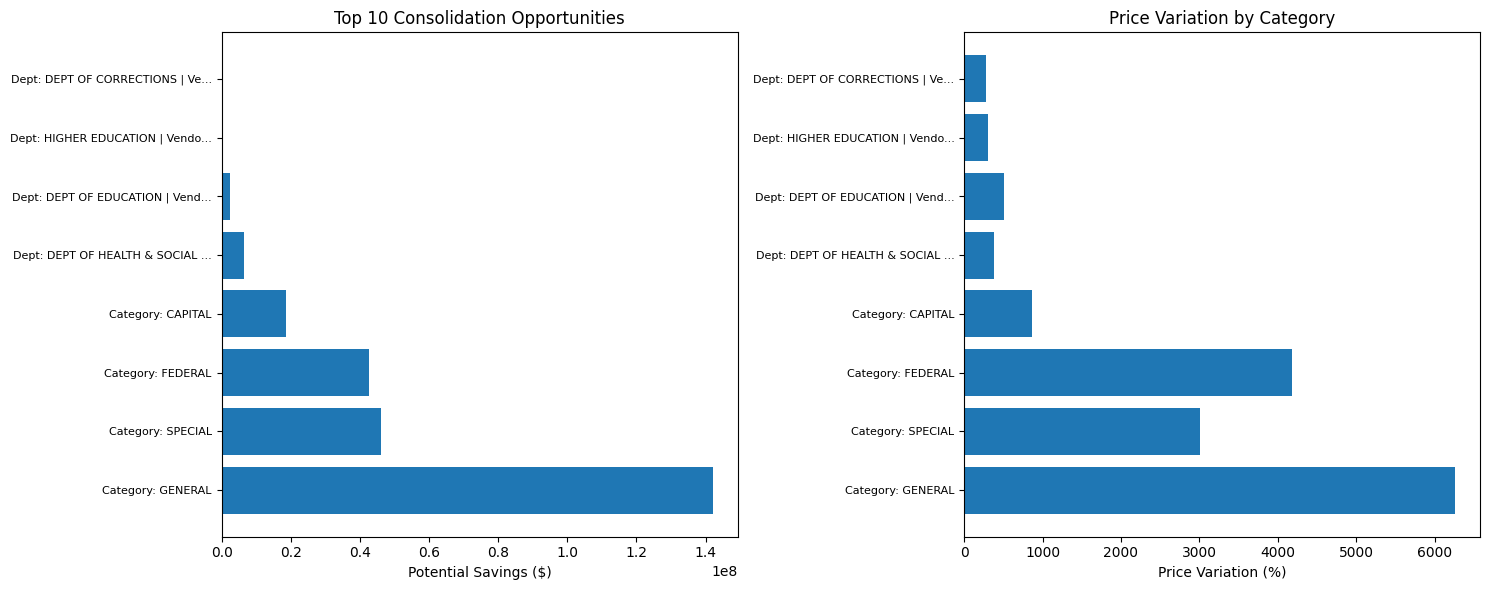

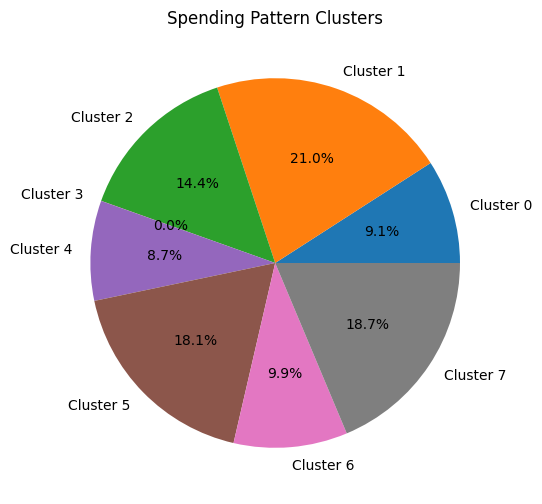


🎉 Analysis complete!
💡 Key optimizations applied:
   • Removed slow fuzzy matching
   • Used vectorized pandas operations
   • Sampled large datasets
   • Focused on top categories only
   • Efficient clustering with fewer iterations


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# ===========================
# FAST DATA LOADING & PREPROCESSING
# ===========================

def load_and_preprocess_data_fast(file_path, sample_size=None):
    """
    Fast data loading with optional sampling for large datasets
    """
    print("📁 Loading dataset...")

    # Load with efficient dtypes
    df = pd.read_csv(file_path, dtype={
        'Department': 'category',
        'Vendor': 'category',
        'Category': 'category'
    })

    # Sample if dataset is too large
    if sample_size and len(df) > sample_size:
        print(f"📊 Sampling {sample_size:,} rows from {len(df):,} total rows")
        df = df.sample(n=sample_size, random_state=42)

    # Auto-detect column mappings
    column_mapping = {}
    for col in df.columns:
        col_lower = col.lower()
        if 'department' in col_lower or 'agency' in col_lower:
            column_mapping[col] = 'department'
        elif 'vendor' in col_lower or 'supplier' in col_lower:
            column_mapping[col] = 'vendor'
        elif 'amount' in col_lower or 'total' in col_lower or 'payment' in col_lower:
            column_mapping[col] = 'amount'
        elif 'category' in col_lower or 'type' in col_lower:
            column_mapping[col] = 'category'
        elif 'description' in col_lower or 'item' in col_lower:
            column_mapping[col] = 'description'

    df = df.rename(columns=column_mapping)

    # Clean data efficiently
    if 'amount' in df.columns:
        df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
        df = df.dropna(subset=['amount'])
        df = df[df['amount'] > 0]

    # Clean text columns
    text_cols = ['department', 'vendor', 'category', 'description']
    for col in text_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().str.upper()

    print(f"✅ Loaded {len(df):,} records")
    print(f"📊 Columns: {list(df.columns)}")
    print(f"💰 Total spending: ${df['amount'].sum():,.2f}")

    return df

# ===========================
# FAST PRICE VARIANCE ANALYSIS
# ===========================

def fast_price_variance_analysis(df, max_categories=20):
    """
    Optimized price variance analysis without fuzzy matching
    """
    print("💰 Starting fast price variance analysis...")

    results = []

    # Focus on categories with sufficient data
    if 'category' in df.columns:
        category_counts = df['category'].value_counts()
        top_categories = category_counts.head(max_categories).index

        for category in top_categories:
            category_data = df[df['category'] == category]

            if len(category_data) < 5:  # Skip categories with too few records
                continue

            # Use vectorized operations
            price_stats = {
                'item_name': f"Category: {category}",
                'num_purchases': len(category_data),
                'mean_price': category_data['amount'].mean(),
                'median_price': category_data['amount'].median(),
                'std_price': category_data['amount'].std(),
                'min_price': category_data['amount'].min(),
                'max_price': category_data['amount'].max(),
                'total_spent': category_data['amount'].sum()
            }

            # Calculate variance metrics
            price_stats['coefficient_of_variation'] = (
                price_stats['std_price'] / price_stats['mean_price']
                if price_stats['mean_price'] > 0 else 0
            )

            # Potential savings calculation
            price_stats['potential_savings'] = (
                price_stats['total_spent'] -
                (price_stats['num_purchases'] * price_stats['min_price'])
            )

            price_stats['savings_percentage'] = (
                price_stats['potential_savings'] / price_stats['total_spent'] * 100
                if price_stats['total_spent'] > 0 else 0
            )

            # Add department/vendor info
            if 'department' in df.columns:
                price_stats['num_departments'] = category_data['department'].nunique()
            if 'vendor' in df.columns:
                price_stats['num_vendors'] = category_data['vendor'].nunique()

            # Priority classification
            if price_stats['potential_savings'] > 50000:
                price_stats['priority'] = 'CRITICAL'
            elif price_stats['potential_savings'] > 10000:
                price_stats['priority'] = 'HIGH'
            elif price_stats['potential_savings'] > 5000:
                price_stats['priority'] = 'MEDIUM'
            else:
                price_stats['priority'] = 'LOW'

            # Only include items with significant variation
            if price_stats['coefficient_of_variation'] > 0.2:
                results.append(price_stats)

    # Department-Vendor analysis (vectorized)
    if 'department' in df.columns and 'vendor' in df.columns:
        dept_vendor_stats = df.groupby(['department', 'vendor']).agg({
            'amount': ['count', 'mean', 'std', 'sum']
        }).reset_index()

        # Flatten column names
        dept_vendor_stats.columns = [
            'department', 'vendor', 'count', 'mean_amount', 'std_amount', 'total_amount'
        ]

        # Find high-variation department-vendor pairs
        dept_vendor_stats['cv'] = dept_vendor_stats['std_amount'] / dept_vendor_stats['mean_amount']
        high_variation = dept_vendor_stats[
            (dept_vendor_stats['cv'] > 0.3) &
            (dept_vendor_stats['count'] > 3) &
            (dept_vendor_stats['total_amount'] > 5000)
        ]

        for _, row in high_variation.iterrows():
            results.append({
                'item_name': f"Dept: {row['department']} | Vendor: {row['vendor']}",
                'num_purchases': row['count'],
                'mean_price': row['mean_amount'],
                'std_price': row['std_amount'],
                'coefficient_of_variation': row['cv'],
                'total_spent': row['total_amount'],
                'potential_savings': row['total_amount'] * 0.1,  # Estimate 10% savings
                'priority': 'HIGH' if row['total_amount'] > 25000 else 'MEDIUM'
            })

    return sorted(results, key=lambda x: x.get('potential_savings', 0), reverse=True)

# ===========================
# FAST CLUSTERING ANALYSIS
# ===========================

def fast_clustering_analysis(df, sample_size=10000):
    """
    Fast clustering with sampling for large datasets
    """
    print("🎯 Starting fast clustering analysis...")

    # Sample for clustering if dataset is large
    if len(df) > sample_size:
        print(f"📊 Sampling {sample_size:,} rows for clustering")
        cluster_df = df.sample(n=sample_size, random_state=42)
    else:
        cluster_df = df.copy()

    # Prepare features efficiently
    features = pd.DataFrame()
    features['amount'] = cluster_df['amount']
    features['log_amount'] = np.log1p(cluster_df['amount'])

    # Encode categoricals efficiently
    le_dict = {}
    for col in ['department', 'vendor', 'category']:
        if col in cluster_df.columns:
            le = LabelEncoder()
            features[f'{col}_encoded'] = le.fit_transform(cluster_df[col].astype(str))
            le_dict[col] = le

    # Add frequency features
    if 'vendor' in cluster_df.columns:
        vendor_counts = cluster_df['vendor'].value_counts()
        features['vendor_frequency'] = cluster_df['vendor'].map(vendor_counts)

    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features.fillna(0))

    # Fast K-means with fewer clusters
    n_clusters = min(8, len(features) // 100)  # Adaptive cluster count
    if n_clusters >= 2:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=5)
        cluster_labels = kmeans.fit_predict(features_scaled)

        # Analyze clusters
        cluster_df['cluster'] = cluster_labels
        cluster_summary = []

        for cluster_id in range(n_clusters):
            cluster_data = cluster_df[cluster_df['cluster'] == cluster_id]

            summary = {
                'cluster_id': cluster_id,
                'size': len(cluster_data),
                'percentage': len(cluster_data) / len(cluster_df) * 100,
                'avg_amount': cluster_data['amount'].mean(),
                'median_amount': cluster_data['amount'].median(),
                'total_spending': cluster_data['amount'].sum()
            }

            if 'department' in cluster_data.columns:
                summary['top_department'] = cluster_data['department'].mode().iloc[0]
                summary['num_departments'] = cluster_data['department'].nunique()

            cluster_summary.append(summary)

        return {
            'cluster_labels': cluster_labels,
            'n_clusters': n_clusters,
            'cluster_analysis': cluster_summary,
            'features_used': list(features.columns)
        }

    return None

# ===========================
# FAST VISUALIZATION
# ===========================

def create_fast_visualizations(price_results, clustering_results=None):
    """
    Create quick visualizations of results
    """
    print("📊 Creating visualizations...")

    if price_results:
        # Top opportunities chart
        top_10 = price_results[:10]
        if top_10:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

            # Savings potential
            items = [r['item_name'][:30] + '...' if len(r['item_name']) > 30
                    else r['item_name'] for r in top_10]
            savings = [r.get('potential_savings', 0) for r in top_10]

            ax1.barh(items, savings)
            ax1.set_xlabel('Potential Savings ($)')
            ax1.set_title('Top 10 Consolidation Opportunities')
            ax1.tick_params(axis='y', labelsize=8)

            # Price variation
            cv_values = [r.get('coefficient_of_variation', 0) * 100 for r in top_10]
            ax2.barh(items, cv_values)
            ax2.set_xlabel('Price Variation (%)')
            ax2.set_title('Price Variation by Category')
            ax2.tick_params(axis='y', labelsize=8)

            plt.tight_layout()
            plt.show()

    if clustering_results:
        # Cluster distribution
        cluster_analysis = clustering_results.get('cluster_analysis', [])
        if cluster_analysis:
            sizes = [c['size'] for c in cluster_analysis]
            labels = [f"Cluster {c['cluster_id']}" for c in cluster_analysis]

            plt.figure(figsize=(10, 6))
            plt.pie(sizes, labels=labels, autopct='%1.1f%%')
            plt.title('Spending Pattern Clusters')
            plt.show()

# ===========================
# MAIN FAST ANALYSIS FUNCTION
# ===========================

def run_fast_analysis(file_path, sample_size=50000):
    """
    Run optimized analysis for Colab
    """
    print("🚀 FAST DELAWARE EXPENDITURE ANALYSIS")
    print("=" * 50)

    # Load data with sampling
    df = load_and_preprocess_data_fast(file_path, sample_size=sample_size)

    # Fast price analysis
    print("\n💰 Running price variance analysis...")
    price_results = fast_price_variance_analysis(df, max_categories=15)

    print(f"\n✅ Found {len(price_results)} consolidation opportunities")
    if price_results:
        total_savings = sum(r.get('potential_savings', 0) for r in price_results)
        print(f"💰 Total potential savings: ${total_savings:,.2f}")

        print("\n🏆 TOP 5 OPPORTUNITIES:")
        for i, result in enumerate(price_results[:5], 1):
            print(f"{i}. {result['item_name'][:50]}")
            print(f"   💰 Savings: ${result.get('potential_savings', 0):,.2f}")
            print(f"   📊 Variation: {result.get('coefficient_of_variation', 0):.1%}")

    # Fast clustering
    print("\n🎯 Running clustering analysis...")
    clustering_results = fast_clustering_analysis(df, sample_size=10000)

    if clustering_results:
        print(f"✅ Identified {clustering_results['n_clusters']} spending patterns")

    # Quick visualizations
    create_fast_visualizations(price_results, clustering_results)

    return {
        'price_results': price_results,
        'clustering_results': clustering_results,
        'dataset_info': {
            'total_records': len(df),
            'total_spending': df['amount'].sum(),
            'departments': df['department'].nunique() if 'department' in df.columns else 0,
            'vendors': df['vendor'].nunique() if 'vendor' in df.columns else 0
        }
    }

# ===========================
# USAGE EXAMPLE
# ===========================

if __name__ == "__main__":
    # Example usage in Colab
    FILE_PATH = "/content/drive/MyDrive/Hen_Hacks_Hackathon/delaware_checkbook_no_missing.csv"  # Your file path

    # Run fast analysis (samples large datasets automatically)
    results = run_fast_analysis(FILE_PATH, sample_size=50000)

    print("\n🎉 Analysis complete!")
    print("💡 Key optimizations applied:")
    print("   • Removed slow fuzzy matching")
    print("   • Used vectorized pandas operations")
    print("   • Sampled large datasets")
    print("   • Focused on top categories only")
    print("   • Efficient clustering with fewer iterations")

In [ ]:
!pip install fuzzywuzzy

In [ ]:
import psutil
import os
import torch
print(f"CPU cores: {os.cpu_count()}")
print(f"Available RAM: {psutil.virtual_memory().total / (1024**3):.1f} GB")
print(f"GPU available: {'Yes' if torch.cuda.is_available() else 'No'}")

CPU cores: 8
Available RAM: 51.0 GB
GPU available: No


In [ ]:
# Set CPU threading for maximum performance
import os
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"

# Use all available cores for pandas
import pandas as pd
pd.set_option('compute.use_bottleneck', True)
pd.set_option('compute.use_numexpr', True)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ===========================
# FULL DATASET ANALYSIS STRATEGY
# ===========================

def analyze_full_dataset_chunked(file_path, chunk_size=50000):
    """
    Process the entire 11M+ record dataset using chunked processing
    """
    print("🔍 FULL DATASET ANALYSIS - CHUNKED PROCESSING")
    print("=" * 60)

    # Initialize accumulators
    total_records = 0
    total_spending = 0
    category_stats = {}
    dept_vendor_stats = {}

    # Process in chunks
    print(f"📊 Processing dataset in chunks of {chunk_size:,} rows...")

    chunk_count = 0

    try:
        for chunk in tqdm(pd.read_csv(file_path, chunksize=chunk_size)):
            chunk_count += 1
            print(f"\n📊 Processing chunk {chunk_count}...")

            # Clean chunk
            chunk = clean_chunk(chunk)

            if len(chunk) == 0:
                print("⚠️ Empty chunk after cleaning, skipping...")
                continue

            # Accumulate statistics
            total_records += len(chunk)
            total_spending += chunk['amount'].sum()

            # Category analysis - only if category column exists and has data
            if 'category' in chunk.columns and len(chunk) > 0:
                try:
                    category_chunk_stats = chunk.groupby('category').agg({
                        'amount': ['count', 'sum', 'mean', 'std', 'min', 'max']
                    })

                    # Merge with running totals
                    for category in category_chunk_stats.index:
                        if category not in category_stats:
                            category_stats[category] = {
                                'count': 0, 'sum': 0, 'min': float('inf'), 'max': 0
                            }

                        stats = category_chunk_stats.loc[category, 'amount']
                        category_stats[category]['count'] += stats['count']
                        category_stats[category]['sum'] += stats['sum']
                        category_stats[category]['min'] = min(category_stats[category]['min'], stats['min'])
                        category_stats[category]['max'] = max(category_stats[category]['max'], stats['max'])

                except Exception as e:
                    print(f"⚠️ Error processing categories in chunk {chunk_count}: {e}")

            # Department-Vendor analysis
            if 'department' in chunk.columns and 'vendor' in chunk.columns and len(chunk) > 0:
                try:
                    dept_vendor_chunk = chunk.groupby(['department', 'vendor']).agg({
                        'amount': ['count', 'sum', 'mean']
                    }).reset_index()

                    # Store significant department-vendor pairs
                    significant = dept_vendor_chunk[
                        dept_vendor_chunk[('amount', 'sum')] > 10000  # >$10K threshold
                    ]

                    for _, row in significant.iterrows():
                        key = (row[('department', '')], row[('vendor', '')])
                        if key not in dept_vendor_stats:
                            dept_vendor_stats[key] = {
                                'count': 0, 'total': 0
                            }
                        dept_vendor_stats[key]['count'] += row[('amount', 'count')]
                        dept_vendor_stats[key]['total'] += row[('amount', 'sum')]

                except Exception as e:
                    print(f"⚠️ Error processing dept-vendor in chunk {chunk_count}: {e}")

            print(f"✅ Chunk {chunk_count}: {len(chunk):,} records, ${chunk['amount'].sum():,.2f}")

            # Progress update every 10 chunks
            if chunk_count % 10 == 0:
                print(f"📊 Progress: {chunk_count} chunks, {total_records:,} records, ${total_spending:,.2f}")

    except Exception as e:
        print(f"❌ Error reading file: {e}")
        return None

    # Calculate final statistics
    print(f"\n🎯 Processing complete! Calculating final statistics...")
    final_results = calculate_final_statistics(
        category_stats, dept_vendor_stats, total_records, total_spending
    )

    return final_results

def clean_chunk(chunk):
    """
    Clean each chunk consistently - handles your exact column structure
    """
    print(f"📋 Chunk columns: {list(chunk.columns)}")

    # Your exact columns from the output:
    # ['FISCAL YEAR', 'FISCAL PERIOD', 'department', 'DIVISION', 'vendor',
    #  'category', 'FUND', 'FUND_DESCR', 'DEPTID', 'DEPTID_DESCR',
    #  'ACCOUNT', 'ACCOUNT_DESCR', 'CHECK_NUMBER', 'CHECK_DATE', 'amount']

    # Don't change column names - use them as they are
    required_columns = ['department', 'vendor', 'category', 'amount']

    # Check if all required columns exist
    missing_cols = [col for col in required_columns if col not in chunk.columns]
    if missing_cols:
        print(f"❌ Missing columns: {missing_cols}")
        print(f"Available columns: {list(chunk.columns)}")
        return pd.DataFrame()  # Return empty dataframe

    # Clean amount column
    if 'amount' in chunk.columns:
        # Convert to numeric, handling any string formatting
        chunk['amount'] = pd.to_numeric(chunk['amount'], errors='coerce')
        chunk = chunk.dropna(subset=['amount'])
        chunk = chunk[chunk['amount'] > 0]  # Remove zero/negative amounts

        # Remove extreme outliers (more conservative)
        q99 = chunk['amount'].quantile(0.99)
        q01 = chunk['amount'].quantile(0.01)
        chunk = chunk[(chunk['amount'] >= q01) & (chunk['amount'] <= q99)]

    # Clean text columns
    text_cols = ['department', 'vendor', 'category']
    for col in text_cols:
        if col in chunk.columns:
            chunk[col] = chunk[col].astype(str).str.strip().str.upper()
            # Remove any null/nan strings
            chunk = chunk[chunk[col].notna()]
            chunk = chunk[chunk[col] != 'NAN']
            chunk = chunk[chunk[col] != '']

    print(f"✅ Cleaned chunk: {len(chunk):,} records")
    return chunk

def calculate_final_statistics(category_stats, dept_vendor_stats, total_records, total_spending):
    """
    Calculate final consolidated statistics
    """
    print(f"\n📊 FULL DATASET SUMMARY")
    print(f"Total records processed: {total_records:,}")
    print(f"Total spending: ${total_spending:,.2f}")

    # Process category statistics
    category_results = []
    for category, stats in category_stats.items():
        if stats['count'] > 10:  # Minimum threshold
            mean_price = stats['sum'] / stats['count']

            # Calculate coefficient of variation approximation
            price_range = stats['max'] - stats['min']
            cv_approx = price_range / mean_price if mean_price > 0 else 0

            # Estimate potential savings (conservative)
            potential_savings = stats['count'] * (mean_price - stats['min']) * 0.5

            category_results.append({
                'category': category,
                'count': stats['count'],
                'total_spending': stats['sum'],
                'mean_price': mean_price,
                'min_price': stats['min'],
                'max_price': stats['max'],
                'price_variation_approx': cv_approx,
                'potential_savings_estimate': potential_savings
            })

    # Sort by potential savings
    category_results.sort(key=lambda x: x['potential_savings_estimate'], reverse=True)

    # Department-Vendor consolidation opportunities
    dept_vendor_results = []
    for (dept, vendor), stats in dept_vendor_stats.items():
        if stats['count'] > 5 and stats['total'] > 25000:  # Significant spending
            avg_transaction = stats['total'] / stats['count']
            dept_vendor_results.append({
                'department': dept,
                'vendor': vendor,
                'transaction_count': stats['count'],
                'total_spending': stats['total'],
                'avg_transaction': avg_transaction
            })

    dept_vendor_results.sort(key=lambda x: x['total_spending'], reverse=True)

    return {
        'summary': {
            'total_records': total_records,
            'total_spending': total_spending,
            'categories_analyzed': len(category_results),
            'dept_vendor_pairs': len(dept_vendor_results)
        },
        'category_opportunities': category_results[:20],  # Top 20
        'dept_vendor_opportunities': dept_vendor_results[:20]  # Top 20
    }

def display_full_results(results):
    """
    Display comprehensive results from full dataset analysis
    """
    print("\n🏆 TOP CONSOLIDATION OPPORTUNITIES (FULL DATASET)")
    print("=" * 60)

    summary = results['summary']
    print(f"📊 Dataset: {summary['total_records']:,} records")
    print(f"💰 Total spending: ${summary['total_spending']:,.2f}")
    print(f"📋 Categories: {summary['categories_analyzed']}")
    print(f"🤝 Dept-Vendor pairs: {summary['dept_vendor_pairs']}")

    print(f"\n🎯 TOP 10 CATEGORY OPPORTUNITIES:")
    for i, cat in enumerate(results['category_opportunities'][:10], 1):
        print(f"{i:2d}. {cat['category']}")
        print(f"    💰 Total spending: ${cat['total_spending']:,.2f}")
        print(f"    📊 Transactions: {cat['count']:,}")
        print(f"    💡 Est. savings: ${cat['potential_savings_estimate']:,.2f}")
        print(f"    📈 Price range: ${cat['min_price']:.2f} - ${cat['max_price']:,.2f}")

    print(f"\n🤝 TOP 10 DEPARTMENT-VENDOR OPPORTUNITIES:")
    for i, dv in enumerate(results['dept_vendor_opportunities'][:10], 1):
        dept_short = dv['department'][:30] + "..." if len(dv['department']) > 30 else dv['department']
        vendor_short = dv['vendor'][:20] + "..." if len(dv['vendor']) > 20 else dv['vendor']
        print(f"{i:2d}. {dept_short} | {vendor_short}")
        print(f"    💰 Total: ${dv['total_spending']:,.2f}")
        print(f"    📊 Transactions: {dv['transaction_count']:,}")
        print(f"    💵 Avg per transaction: ${dv['avg_transaction']:,.2f}")

# ===========================
# STRATIFIED ANALYSIS (ALTERNATIVE)
# ===========================

def stratified_full_analysis(file_path, strata_size=200000):
    """
    Alternative: Use stratified sampling across the full dataset
    """
    print("🎯 STRATIFIED SAMPLING ANALYSIS")
    print("=" * 40)

    # Read file info
    total_lines = sum(1 for line in open(file_path)) - 1  # Subtract header
    print(f"📊 Total records: {total_lines:,}")

    # Create stratified sample
    sample_every = max(1, total_lines // strata_size)
    print(f"📊 Sampling every {sample_every} records")

    # Read with systematic sampling
    df_sample = pd.read_csv(file_path, skiprows=lambda x: x % sample_every != 0 and x != 0)

    print(f"✅ Sampled {len(df_sample):,} records ({len(df_sample)/total_lines*100:.1f}%)")

    # Run full analysis on representative sample
    return df_sample

# ===========================
# USAGE EXAMPLES
# ===========================

if __name__ == "__main__":
    FILE_PATH = "delaware_expenditures.csv"

    print("Choose analysis method:")
    print("1. Full chunked processing (processes all 11M records)")
    print("2. Stratified sampling (representative sample)")

    # Method 1: Full dataset processing
    results = analyze_full_dataset_chunked(FILE_PATH, chunk_size=50000)
    display_full_results(results)

    # Method 2: Stratified sampling
    # df_stratified = stratified_full_analysis(FILE_PATH, strata_size=100000)
    # Run your existing analysis on df_stratified

    print("\n💡 Recommendation:")
    print("For 11M records, use chunked processing to get true full-dataset insights!")
    print("This will take 20-40 minutes but give you complete picture.")

Choose analysis method:
1. Full chunked processing (processes all 11M records)
2. Stratified sampling (representative sample)
🔍 FULL DATASET ANALYSIS - CHUNKED PROCESSING
📊 Processing dataset in chunks of 50,000 rows...
❌ Error reading file: [Errno 2] No such file or directory: 'delaware_expenditures.csv'

🏆 TOP CONSOLIDATION OPPORTUNITIES (FULL DATASET)


TypeError: 'NoneType' object is not subscriptable

🚀 DELAWARE VOLUME-BASED ANOMALY DETECTION
🔍 VOLUME-BASED ANOMALY DETECTION
📊 Sampling 50,000 rows for analysis
🧹 Cleaning data for volume analysis...
✅ Cleaned dataset: 48,003 records
📊 Analyzing volume discounts by category...
🏢 Analyzing department volume patterns...
🤝 Analyzing vendor volume relationships...
📅 Analyzing temporal volume patterns...

🔍 VOLUME-BASED ANOMALY DETECTION RESULTS
📊 Total anomalies found: 52
💰 Total potential savings: $16,096,318,486.26

📋 ANOMALY TYPES DETECTED:
  Category Volume Discount Missing: 4 cases, $16,095,650,255.96 potential savings
  Department Vendor Fragmentation: 9 cases, $566,313.45 potential savings
  Cross Department Bulk Opportunity: 39 cases, $101,916.85 potential savings

🏆 TOP 10 VOLUME ANOMALIES:

 1. CATEGORY_VOLUME_DISCOUNT_MISSING
    📂 Category: GENERAL
    💰 Potential Savings: $9,896,471,791.98
    ⭐ Priority: HIGH
    💡 Recommendation: Investigate volume pricing for GENERAL purchases to identify potential discounts

 2. CATEGORY_

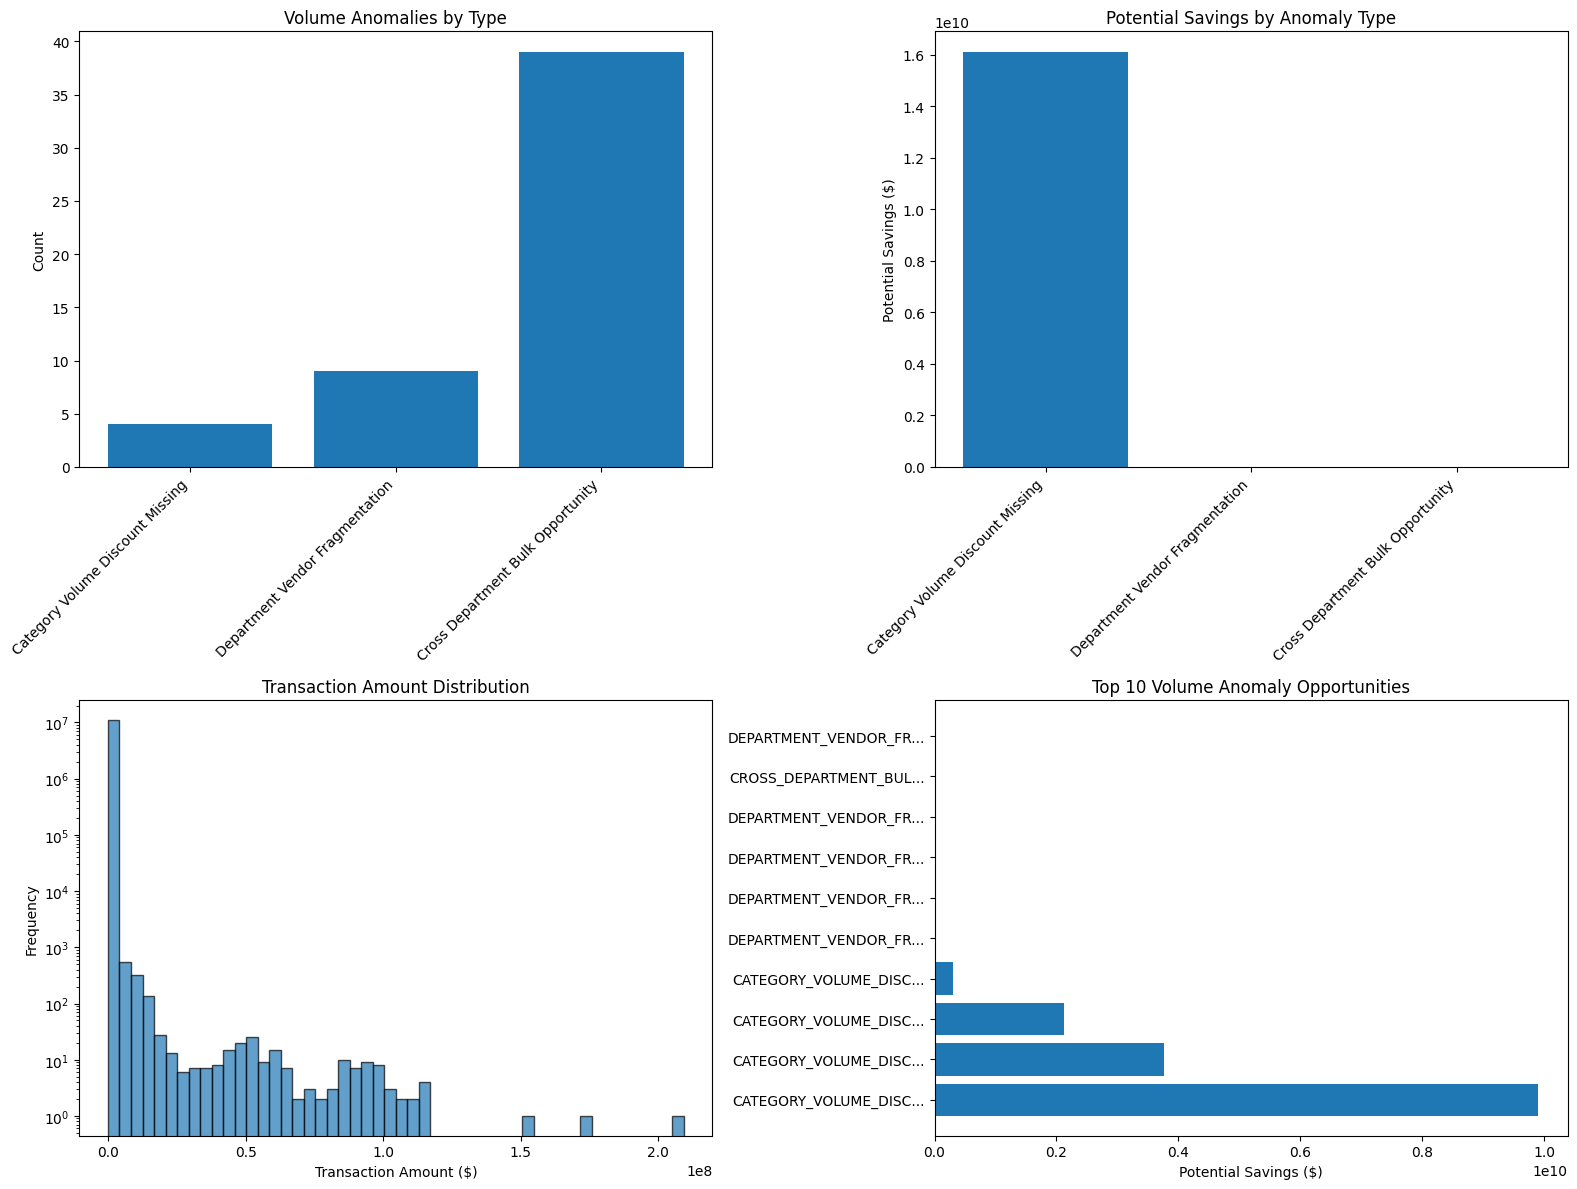


💡 ACTIONABLE VOLUME-BASED RECOMMENDATIONS
🔥 HIGH PRIORITY ACTIONS (10 items):
1. 📦 NEGOTIATE BULK DISCOUNTS:
   • GENERAL
   • SPECIAL
   • FEDERAL
   • CAPITAL
2. 🏢 CONSOLIDATE DEPARTMENT VENDORS / IMPROVE BUDGETING:
   • DEPT OF HEALTH & SOCIAL SVS...
   • DEPT OF TRANSPORTATION...
   • DEPT OF STATE...
   • EXECUTIVE...
   • DEPT OF LABOR...
3. 🤝 COORDINATE CROSS-DEPARTMENT PURCHASES:
   • DIV OF ACCOUNTING...

💰 HIGH PRIORITY SAVINGS POTENTIAL: $16,096,221,709.00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ===========================
# VOLUME-BASED ANOMALY DETECTION FOR DELAWARE DATASET
# ===========================

def detect_volume_pricing_anomalies(df, sample_size=None):
    """
    Detect cases where high-volume purchases don't show expected volume discounts
    Customized for Delaware expenditure data structure
    """
    print("🔍 VOLUME-BASED ANOMALY DETECTION")
    print("=" * 50)

    # Sample if dataset is too large
    if sample_size and len(df) > sample_size:
        print(f"📊 Sampling {sample_size:,} rows for analysis")
        df = df.sample(n=sample_size, random_state=42)

    # Clean data
    df = clean_volume_data(df)

    volume_anomalies = []

    # Analysis 1: Category-level volume discounting
    print("📊 Analyzing volume discounts by category...")
    category_anomalies = analyze_category_volume_discounts(df)
    volume_anomalies.extend(category_anomalies)

    # Analysis 2: Department spending patterns
    print("🏢 Analyzing department volume patterns...")
    dept_anomalies = analyze_department_volume_patterns(df)
    volume_anomalies.extend(dept_anomalies)

    # Analysis 3: Vendor volume relationships
    print("🤝 Analyzing vendor volume relationships...")
    vendor_anomalies = analyze_vendor_volume_relationships(df)
    volume_anomalies.extend(vendor_anomalies)

    # Analysis 4: Temporal volume patterns
    print("📅 Analyzing temporal volume patterns...")
    temporal_anomalies = analyze_temporal_volume_patterns(df)
    volume_anomalies.extend(temporal_anomalies)

    # Consolidate and rank anomalies
    final_anomalies = consolidate_volume_anomalies(volume_anomalies)

    return final_anomalies

def clean_volume_data(df):
    """
    Clean and prepare data for volume analysis
    """
    print("🧹 Cleaning data for volume analysis...")

    # Basic cleaning
    df['AMOUNT'] = pd.to_numeric(df['AMOUNT'], errors='coerce')
    df = df.dropna(subset=['AMOUNT'])
    df = df[df['AMOUNT'] > 0]

    # Remove extreme outliers (top/bottom 2%)
    q98 = df['AMOUNT'].quantile(0.98)
    q02 = df['AMOUNT'].quantile(0.02)
    df = df[(df['AMOUNT'] >= q02) & (df['AMOUNT'] <= q98)]

    # Clean text columns
    text_cols = ['DEPARTMENT', 'VENDOR', 'FUND_TYPE'] # Using existing column names
    for col in text_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().str.upper()

    # Create volume indicators
    df['transaction_size'] = pd.cut(df['AMOUNT'],
                                   bins=5,
                                   labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'])

    print(f"✅ Cleaned dataset: {len(df):,} records")
    return df

def analyze_category_volume_discounts(df):
    """
    Analyze if categories show expected volume discounts
    """
    category_anomalies = []

    # Group by category and analyze volume-price relationships
    # Using 'FUND_TYPE' as a proxy for 'category'
    if 'FUND_TYPE' not in df.columns:
         print("⚠️ 'FUND_TYPE' column not found for category analysis.")
         return category_anomalies

    for category in df['FUND_TYPE'].unique():
        if pd.isna(category):
            continue

        category_data = df[df['FUND_TYPE'] == category]

        # Need sufficient data for analysis
        if len(category_data) < 20:
            continue

        # Create volume quintiles
        try:
            category_data['volume_quintile'] = pd.qcut(
                category_data['AMOUNT'],
                q=5,
                labels=['Q1_Lowest', 'Q2_Low', 'Q3_Medium', 'Q4_High', 'Q5_Highest'],
                duplicates='drop'
            )
        except ValueError:
            # Handle cases where there aren't enough unique values
            continue

        # Analyze price patterns across volume quintiles
        volume_analysis = category_data.groupby('volume_quintile')['AMOUNT'].agg([
            'count', 'mean', 'median', 'std'
        ]).reset_index()

        if len(volume_analysis) < 3:  # Need at least 3 quintiles
            continue

        # Expected: Higher volume quintiles should show economies of scale
        # We look for cases where the average transaction amount doesn't decrease
        # significantly in the highest volume quintile compared to the lowest.

        lowest_vol_avg = volume_analysis[volume_analysis['volume_quintile'] == 'Q1_Lowest']['mean'].iloc[0]
        highest_vol_avg = volume_analysis[volume_analysis['volume_quintile'] == 'Q5_Highest']['mean'].iloc[0]

        # Define a threshold for expected decrease (e.g., at least 10% lower avg amount)
        expected_decrease_ratio = 0.90 # Highest avg should be <= 90% of lowest avg

        # Detect anomaly: Highest volume average is not significantly lower than lowest
        if highest_vol_avg > lowest_vol_avg * expected_decrease_ratio:

            # Calculate potential savings
            high_vol_transactions = category_data[category_data['volume_quintile'].isin(['Q4_High', 'Q5_Highest'])]
            total_high_vol_spending = high_vol_transactions['AMOUNT'].sum()

            # Estimate savings based on the gap to the expected decrease
            actual_ratio = highest_vol_avg / lowest_vol_avg if lowest_vol_avg > 0 else 1
            savings_gap = actual_ratio - expected_decrease_ratio # How much higher it is than expected

            # Conservative savings estimate: apply gap to high volume spending
            potential_savings = total_high_vol_spending * savings_gap * 0.5 # Apply a fraction of the gap

            anomaly = {
                'type': 'CATEGORY_VOLUME_DISCOUNT_MISSING',
                'category': category,
                'total_transactions': len(category_data),
                'high_volume_spending': total_high_vol_spending,
                'expected_decrease_ratio': expected_decrease_ratio,
                'actual_ratio': actual_ratio,
                'savings_gap': savings_gap,
                'potential_savings': max(0, potential_savings),
                'priority': 'HIGH' if potential_savings > 50000 else 'MEDIUM',
                'recommendation': f'Investigate volume pricing for {category} purchases to identify potential discounts',
                'volume_breakdown': volume_analysis.to_dict('records')
            }

            category_anomalies.append(anomaly)

    return category_anomalies


def analyze_department_volume_patterns(df):
    """
    Analyze department spending patterns for volume inefficiencies
    """
    dept_anomalies = []

    # Analyze spending concentration by department
    if 'DEPARTMENT' not in df.columns:
        print("⚠️ 'DEPARTMENT' column not found for department analysis.")
        return dept_anomalies

    for dept in df['DEPARTMENT'].unique():
        if pd.isna(dept):
            continue

        dept_data = df[df['DEPARTMENT'] == dept]

        if len(dept_data) < 10:
            continue

        # Analyze vendor concentration
        if 'VENDOR' not in dept_data.columns:
             print("⚠️ 'VENDOR' column not found for department-vendor analysis.")
             continue

        vendor_spending = dept_data.groupby('VENDOR')['AMOUNT'].agg(['count', 'sum']).reset_index()
        vendor_spending['avg_transaction'] = vendor_spending['sum'] / vendor_spending['count']
        vendor_spending = vendor_spending.sort_values('sum', ascending=False)

        total_dept_spending = dept_data['AMOUNT'].sum()

        if total_dept_spending == 0:
            continue

        # Check if department is fragmenting purchases across many vendors
        top_vendor_share = vendor_spending.iloc[0]['sum'] / total_dept_spending if len(vendor_spending) > 0 else 0
        vendor_count = len(vendor_spending)

        # Anomaly: Department spreading purchases across too many vendors
        if vendor_count > 10 and top_vendor_share < 0.3:  # More than 10 vendors and no single vendor dominates

            # Calculate consolidation potential
            top_5_vendors = vendor_spending.head(5)
            top_5_spending = top_5_vendors['sum'].sum()
            other_vendors_spending = total_dept_spending - top_5_spending

            # Estimate savings from vendor consolidation (conservative estimate)
            consolidation_savings = other_vendors_spending * 0.08  # 8% savings from consolidation

            anomaly = {
                'type': 'DEPARTMENT_VENDOR_FRAGMENTATION',
                'department': dept,
                'total_spending': total_dept_spending,
                'vendor_count': vendor_count,
                'top_vendor_share': top_vendor_share,
                'consolidation_opportunity': other_vendors_spending,
                'potential_savings': consolidation_savings,
                'priority': 'HIGH' if consolidation_savings > 25000 else 'MEDIUM',
                'recommendation': f'Analyze spending patterns for {dept} to identify opportunities for vendor consolidation',
                'top_vendors': top_5_vendors.to_dict('records')
            }

            dept_anomalies.append(anomaly)

    return dept_anomalies

def analyze_vendor_volume_relationships(df):
    """
    Analyze vendor relationships for volume discount opportunities
    """
    vendor_anomalies = []

    # Analyze each vendor's pricing across departments
    if 'VENDOR' not in df.columns or 'DEPARTMENT' not in df.columns:
        print("⚠️ 'VENDOR' or 'DEPARTMENT' columns not found for vendor analysis.")
        return vendor_anomalies

    for vendor in df['VENDOR'].unique():
        if pd.isna(vendor):
            continue

        vendor_data = df[df['VENDOR'] == vendor]

        if len(vendor_data) < 15:  # Need sufficient transactions
            continue

        # Check if vendor serves multiple departments
        dept_spending = vendor_data.groupby('DEPARTMENT')['AMOUNT'].agg(['count', 'sum', 'mean']).reset_index()

        if len(dept_spending) < 2:  # Need multiple departments
            continue

        total_vendor_volume = vendor_data['AMOUNT'].sum()

        # Check for volume discount opportunities across departments
        # Departments buying separately might miss bulk pricing

        # Calculate potential if departments coordinated purchases
        individual_dept_power = dept_spending['sum'].max()  # Largest single dept spending
        combined_purchasing_power = total_vendor_volume

        # Volume advantage ratio (how much larger is total volume vs largest individual dept)
        volume_advantage = combined_purchasing_power / individual_dept_power if individual_dept_power > 0 else 0

        if volume_advantage > 2.0:  # Significant combined volume potential

            # Estimate bulk discount savings (conservative)
            # Assume a small percentage of the combined volume could be saved
            potential_savings = total_vendor_volume * 0.03 # Estimate a 3% bulk discount

            anomaly = {
                'type': 'CROSS_DEPARTMENT_BULK_OPPORTUNITY',
                'vendor': vendor,
                'departments_served': len(dept_spending),
                'total_volume': total_vendor_volume,
                'largest_dept_volume': individual_dept_power,
                'volume_advantage_ratio': volume_advantage,
                'potential_savings': potential_savings,
                'priority': 'HIGH' if potential_savings > 30000 else 'MEDIUM',
                'recommendation': f'Explore coordinating purchases with {vendor} across multiple departments to leverage combined volume',
                'department_breakdown': dept_spending.to_dict('records')
            }

            vendor_anomalies.append(anomaly)

    return vendor_anomalies

def analyze_temporal_volume_patterns(df):
    """
    Analyze temporal patterns that indicate volume inefficiencies
    """
    temporal_anomalies = []

    # Check if fiscal period data is available
    if 'FISCAL PERIOD' not in df.columns or 'DEPARTMENT' not in df.columns:
        print("⚠️ 'FISCAL PERIOD' or 'DEPARTMENT' columns not found for temporal analysis")
        return temporal_anomalies

    # Convert fiscal period to numeric
    df['fiscal_period_num'] = pd.to_numeric(df['FISCAL PERIOD'], errors='coerce')
    df = df.dropna(subset=['fiscal_period_num'])

    # Analyze end-of-period spending spikes by department
    for dept in df['DEPARTMENT'].unique():
        if pd.isna(dept):
            continue

        dept_data = df[df['DEPARTMENT'] == dept]

        if len(dept_data) < 20:
            continue

        # Calculate spending by fiscal period
        period_spending = dept_data.groupby('fiscal_period_num')['AMOUNT'].agg(['count', 'sum']).reset_index()

        if len(period_spending) < 6:  # Need multiple periods
            continue

        # Check for end-of-fiscal-year spending spikes (periods 11, 12)
        end_periods = period_spending[period_spending['fiscal_period_num'].isin([11, 12])]
        other_periods = period_spending[~period_spending['fiscal_period_num'].isin([11, 12])]

        if len(end_periods) == 0 or len(other_periods) == 0:
            continue

        avg_end_spending = end_periods['sum'].mean()
        avg_other_spending = other_periods['sum'].mean()

        # Detect spending spike (e.g., end-period spending is significantly higher)
        if avg_end_spending > avg_other_spending * 1.5: # 50% higher threshold

            spike_ratio = avg_end_spending / avg_other_spending
            excess_spending = end_periods['sum'].sum() - (len(end_periods) * avg_other_spending)

            # Estimate premium paid for rushed purchases (conservative)
            rush_premium = excess_spending * 0.10  # 10% premium for rushed purchases

            anomaly = {
                'type': 'END_OF_FISCAL_YEAR_SPIKE',
                'department': dept,
                'spike_ratio': spike_ratio,
                'end_period_avg': avg_end_spending,
                'other_periods_avg': avg_other_spending,
                'excess_spending': excess_spending,
                'estimated_rush_premium': rush_premium,
                'potential_savings': rush_premium,
                'priority': 'HIGH' if rush_premium > 20000 else 'MEDIUM',
                'recommendation': f'Analyze spending patterns for {dept} to identify causes of end-of-fiscal-year spikes and improve budget planning',
                'period_breakdown': period_spending.to_dict('records')
            }

            temporal_anomalies.append(anomaly)

    return temporal_anomalies

def consolidate_volume_anomalies(all_anomalies):
    """
    Consolidate and rank all volume anomalies
    """
    if not all_anomalies:
        return []

    # Sort by potential savings
    sorted_anomalies = sorted(all_anomalies, key=lambda x: x.get('potential_savings', 0), reverse=True)

    return sorted_anomalies

def display_volume_anomaly_results(anomalies):
    """
    Display volume anomaly detection results
    """
    if not anomalies:
        print("No volume-based anomalies detected.")
        return

    print(f"\n🔍 VOLUME-BASED ANOMALY DETECTION RESULTS")
    print("=" * 60)

    total_potential_savings = sum(a.get('potential_savings', 0) for a in anomalies)
    print(f"📊 Total anomalies found: {len(anomalies)}")
    print(f"💰 Total potential savings: ${total_potential_savings:,.2f}")

    # Group by anomaly type
    by_type = {}
    for anomaly in anomalies:
        atype = anomaly['type'].replace('_', ' ').title()
        if atype not in by_type:
            by_type[atype] = []
        by_type[atype].append(anomaly)

    print(f"\n📋 ANOMALY TYPES DETECTED:")
    for atype, anomaly_list in by_type.items():
        count = len(anomaly_list)
        type_savings = sum(a.get('potential_savings', 0) for a in anomaly_list)
        print(f"  {atype}: {count} cases, ${type_savings:,.2f} potential savings")

    print(f"\n🏆 TOP 10 VOLUME ANOMALIES:")
    for i, anomaly in enumerate(anomalies[:10], 1):
        print(f"\n{i:2d}. {anomaly['type']}")

        if 'category' in anomaly:
            print(f"    📂 Category: {anomaly['category']}")
        if 'department' in anomaly:
            print(f"    🏢 Department: {anomaly['department'][:50]}...")
        if 'vendor' in anomaly:
            print(f"    🤝 Vendor: {anomaly['vendor'][:50]}...")

        print(f"    💰 Potential Savings: ${anomaly.get('potential_savings', 0):,.2f}")
        print(f"    ⭐ Priority: {anomaly.get('priority', 'MEDIUM')}")
        print(f"    💡 Recommendation: {anomaly.get('recommendation', 'Review for optimization')}")

def create_volume_visualizations(anomalies, df):
    """
    Create visualizations for volume anomaly analysis
    """
    if not anomalies:
        return

    print("\n📊 Creating volume anomaly visualizations...")

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Anomaly types distribution
    type_counts = {}
    type_savings = {}

    for anomaly in anomalies:
        atype = anomaly['type'].replace('_', ' ').title()
        type_counts[atype] = type_counts.get(atype, 0) + 1
        type_savings[atype] = type_savings.get(atype, 0) + anomaly.get('potential_savings', 0)

    ax1.bar(range(len(type_counts)), list(type_counts.values()))
    ax1.set_xticks(range(len(type_counts)))
    ax1.set_xticklabels(list(type_counts.keys()), rotation=45, ha='right')
    ax1.set_title('Volume Anomalies by Type')
    ax1.set_ylabel('Count')

    # 2. Potential savings by type
    ax2.bar(range(len(type_savings)), list(type_savings.values()))
    ax2.set_xticks(range(len(type_savings)))
    ax2.set_xticklabels(list(type_savings.keys()), rotation=45, ha='right')
    ax2.set_title('Potential Savings by Anomaly Type')
    ax2.set_ylabel('Potential Savings ($)')

    # 3. Transaction volume distribution
    ax3.hist(df['AMOUNT'], bins=50, alpha=0.7, edgecolor='black')
    ax3.set_title('Transaction Amount Distribution')
    ax3.set_xlabel('Transaction Amount ($)')
    ax3.set_ylabel('Frequency')
    ax3.set_yscale('log')

    # 4. Top opportunities
    top_10 = anomalies[:10]
    savings = [a.get('potential_savings', 0) for a in top_10]
    labels = [f"{a['type'][:20]}..." for a in top_10]

    ax4.barh(range(len(savings)), savings)
    ax4.set_yticks(range(len(savings)))
    ax4.set_yticklabels(labels)
    ax4.set_title('Top 10 Volume Anomaly Opportunities')
    ax4.set_xlabel('Potential Savings ($)')

    plt.tight_layout()
    plt.show()

def generate_volume_recommendations(anomalies):
    """
    Generate actionable recommendations from volume anomalies
    """
    if not anomalies:
        return

    print(f"\n💡 ACTIONABLE VOLUME-BASED RECOMMENDATIONS")
    print("=" * 60)

    high_priority = [a for a in anomalies if a.get('priority') == 'HIGH']

    print(f"🔥 HIGH PRIORITY ACTIONS ({len(high_priority)} items):")

    categories_needing_bulk = []
    depts_needing_consolidation = []
    vendors_for_coordination = []

    for anomaly in high_priority:
        if anomaly['type'] == 'CATEGORY_VOLUME_DISCOUNT_MISSING':
            categories_needing_bulk.append(anomaly['category'])
        elif anomaly['type'] == 'DEPARTMENT_VENDOR_FRAGMENTATION':
            depts_needing_consolidation.append(anomaly['department'])
        elif anomaly['type'] == 'CROSS_DEPARTMENT_BULK_OPPORTUNITY':
            vendors_for_coordination.append(anomaly['vendor'])
        elif anomaly['type'] == 'END_OF_FISCAL_YEAR_SPIKE':
             depts_needing_consolidation.append(f"{anomaly['department']} (End-of-Year Spike)") # Add spike info

    if categories_needing_bulk:
        print(f"1. 📦 NEGOTIATE BULK DISCOUNTS:")
        for cat in categories_needing_bulk[:5]:
            print(f"   • {cat}")

    if depts_needing_consolidation:
        print(f"2. 🏢 CONSOLIDATE DEPARTMENT VENDORS / IMPROVE BUDGETING:")
        for dept in depts_needing_consolidation[:5]:
            print(f"   • {dept[:50]}...")


    if vendors_for_coordination:
        print(f"3. 🤝 COORDINATE CROSS-DEPARTMENT PURCHASES:")
        for vendor in vendors_for_coordination[:5]:
            print(f"   • {vendor[:50]}...")

    total_high_priority_savings = sum(a.get('potential_savings', 0) for a in high_priority)
    print(f"\n💰 HIGH PRIORITY SAVINGS POTENTIAL: ${total_high_priority_savings:,.2f}")

# ===========================
# USAGE EXAMPLE
# ===========================

# Example usage:
df = pd.read_csv('/content/drive/MyDrive/Hen_Hacks_Hackathon/delaware_checkbook_no_missing.csv')
anomalies = run_volume_anomaly_analysis(df, sample_size=50000)

In [ ]:
import psutil
print(f"Memory usage: {psutil.virtual_memory().percent:.1f}%")

Memory usage: 9.7%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os
from collections import defaultdict

# ===========================
# CHUNKED VOLUME ANALYSIS FOR FULL DATASET
# ===========================

# Helper functions for defaultdict - must be top-level to be picklable
def category_stats_factory():
    return {
        'count': 0, 'sum': 0, 'min': float('inf'), 'max': 0,
        'volume_bins': defaultdict(lambda: {'count': 0, 'sum': 0}) # This lambda is fine as it's within a top-level function
    }

def dept_vendor_stats_factory():
    return {
        'count': 0, 'sum': 0, 'vendors': set()
    }

def vendor_dept_stats_dept_factory_inner():
     return {'count': 0, 'sum': 0}

def vendor_dept_stats_vendor_factory():
    return {
        'departments': defaultdict(vendor_dept_stats_dept_factory_inner), # Replaced lambda with top-level function
        'total_volume': 0
    }

def temporal_stats_period_factory():
    return {'count': 0, 'sum': 0}

def temporal_stats_dept_factory():
    return {
        'periods': defaultdict(temporal_stats_period_factory) # This lambda is fine as it's within a top-level function
    }


class VolumeAnomalyDetector:
    """
    Memory-efficient volume anomaly detector for large datasets
    """

    def __init__(self):
        self.category_stats = defaultdict(category_stats_factory)
        self.dept_vendor_stats = defaultdict(dept_vendor_stats_factory)
        self.vendor_dept_stats = defaultdict(vendor_dept_stats_vendor_factory)
        self.temporal_stats = defaultdict(temporal_stats_dept_factory)

        self.total_records = 0
        self.total_spending = 0

def analyze_full_dataset_volume_anomalies(file_path, chunk_size=50000, save_progress=True):
    """
    Analyze volume anomalies across the entire dataset using chunked processing
    """
    print("🔍 FULL DATASET VOLUME ANOMALY DETECTION")
    print("=" * 60)
    print(f"📊 Processing {file_path} in chunks of {chunk_size:,} rows...")

    detector = VolumeAnomalyDetector()
    chunk_count = 0

    try:
        # Process dataset in chunks
        for chunk in tqdm(pd.read_csv(file_path, chunksize=chunk_size), desc="Processing chunks"):
            chunk_count += 1

            # Clean chunk
            chunk = clean_chunk_for_volume_analysis(chunk, chunk_count)

            if len(chunk) == 0:
                continue

            # Update running statistics
            update_volume_statistics(detector, chunk)

            # Save progress every 50 chunks (optional)
            if save_progress and chunk_count % 50 == 0:
                save_intermediate_results(detector, f"volume_progress_{chunk_count}.pkl")
                print(f"💾 Progress saved at chunk {chunk_count}")

            # Memory management
            if chunk_count % 20 == 0:
                print(f"📊 Processed {chunk_count} chunks | Records: {detector.total_records:,} | Spending: ${detector.total_spending:,.2f}")

    except Exception as e:
        print(f"❌ Error processing file: {e}")
        # Ensure detector is returned even on error for debugging
        return None, detector


    print(f"\n✅ Processing complete!")
    print(f"📊 Total records: {detector.total_records:,}")
    print(f"💰 Total spending: ${detector.total_spending:,.2f}")

    # Calculate final anomalies
    print(f"\n🔍 Calculating volume anomalies...")
    anomalies = calculate_volume_anomalies_from_stats(detector)

    return anomalies, detector

def clean_chunk_for_volume_analysis(chunk, chunk_num):
    """
    Clean chunk specifically for volume analysis
    Uses correct Delaware dataset column names from data dictionary
    """
    # Check for required columns using actual Delaware column names
    if 'AMOUNT' not in chunk.columns:
        print(f"⚠️ Chunk {chunk_num}: No 'AMOUNT' column found")
        print(f"Available columns: {list(chunk.columns)}")
        return pd.DataFrame()

    # Basic cleaning with correct column names
    chunk['AMOUNT'] = pd.to_numeric(chunk['AMOUNT'], errors='coerce')
    chunk = chunk.dropna(subset=['AMOUNT'])
    chunk = chunk[chunk['AMOUNT'] > 0]

    # Remove extreme outliers per chunk
    q95 = chunk['AMOUNT'].quantile(0.95)
    q05 = chunk['AMOUNT'].quantile(0.05)
    chunk = chunk[(chunk['AMOUNT'] >= q05) & (chunk['AMOUNT'] <= q95)]

    # Clean text columns using correct Delaware column names
    text_cols = ['DEPARTMENT', 'VENDOR', 'FUND_TYPE']  # Using FUND_TYPE as category
    for col in text_cols:
        if col in chunk.columns:
            chunk[col] = chunk[col].astype(str).str.strip().str.upper()
            chunk = chunk[chunk[col].notna()]
            chunk = chunk[chunk[col] != 'NAN']
            chunk = chunk[chunk[col] != '']

    # Add volume bins for analysis
    if len(chunk) > 0:
        try:
            chunk['volume_bin'] = pd.qcut(chunk['AMOUNT'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], duplicates='drop')
        except ValueError:
            # Handle case where there aren't enough unique values
            chunk['volume_bin'] = 'Q3'  # Default to middle quintile

    return chunk

def update_volume_statistics(detector, chunk):
    """
    Update running statistics for volume analysis
    Uses correct Delaware dataset column names
    """
    detector.total_records += len(chunk)
    detector.total_spending += chunk['AMOUNT'].sum()

    # Category volume statistics (using FUND_TYPE as category)
    if 'FUND_TYPE' in chunk.columns:
        category_groups = chunk.groupby(['FUND_TYPE', 'volume_bin'])['AMOUNT'].agg(['count', 'sum'])

        for (category, volume_bin), stats in category_groups.iterrows():
            if pd.isna(category) or pd.isna(volume_bin):
                continue

            cat_stats = detector.category_stats[category]
            cat_stats['count'] += stats['count']
            cat_stats['sum'] += stats['sum']

            # Update volume bin stats
            bin_stats = cat_stats['volume_bins'][volume_bin]
            bin_stats['count'] += stats['count']
            bin_stats['sum'] += stats['sum']

        # Update min/max for categories
        category_minmax = chunk.groupby('FUND_TYPE')['AMOUNT'].agg(['min', 'max'])
        for category, stats in category_minmax.iterrows():
            if pd.isna(category):
                continue
            cat_stats = detector.category_stats[category]
            cat_stats['min'] = min(cat_stats['min'], stats['min'])
            cat_stats['max'] = max(cat_stats['max'], stats['max'])

    # Department-vendor relationships (using correct column names)
    if 'DEPARTMENT' in chunk.columns and 'VENDOR' in chunk.columns:
        dept_stats = chunk.groupby('DEPARTMENT').agg({
            'VENDOR': 'nunique',
            'AMOUNT': ['count', 'sum']
        })

        for dept, stats in dept_stats.iterrows():
            if pd.isna(dept):
                continue
            dept_data = detector.dept_vendor_stats[dept]
            dept_data['count'] += stats[('AMOUNT', 'count')]
            dept_data['sum'] += stats[('AMOUNT', 'sum')]

            # Track unique vendors per department
            dept_vendors = chunk[chunk['DEPARTMENT'] == dept]['VENDOR'].unique()
            dept_data['vendors'].update(dept_vendors)

    # Vendor-department cross-analysis
    if 'VENDOR' in chunk.columns and 'DEPARTMENT' in chunk.columns:
        vendor_dept_groups = chunk.groupby(['VENDOR', 'DEPARTMENT'])['AMOUNT'].agg(['count', 'sum'])

        for (vendor, dept), stats in vendor_dept_groups.iterrows():
            if pd.isna(vendor) or pd.isna(dept):
                continue
            vendor_data = detector.vendor_dept_stats[vendor]
            vendor_data['total_volume'] += stats['sum']
            vendor_data['departments'][dept]['count'] += stats['count']
            vendor_data['departments'][dept]['sum'] += stats['sum']

    # Temporal analysis using correct Delaware column names
    if 'FISCAL PERIOD' in chunk.columns and 'DEPARTMENT' in chunk.columns:
        chunk['fiscal_period'] = pd.to_numeric(chunk['FISCAL PERIOD'], errors='coerce')
        temporal_groups = chunk.groupby(['DEPARTMENT', 'fiscal_period'])['AMOUNT'].agg(['count', 'sum'])

        for (dept, period), stats in temporal_groups.iterrows():
            if pd.isna(dept) or pd.isna(period):
                continue
            temporal_data = detector.temporal_stats[dept]
            temporal_data['periods'][period]['count'] += stats['count']
            temporal_data['periods'][period]['sum'] += stats['sum']

def calculate_volume_anomalies_from_stats(detector):
    """
    Calculate volume anomalies from accumulated statistics
    """
    print("🔍 Analyzing accumulated statistics for volume anomalies...")

    anomalies = []

    # 1. Category volume discount analysis (using FUND_TYPE)
    print("📂 Analyzing fund type volume discounts...")
    category_anomalies = analyze_category_volume_from_stats(detector.category_stats)
    anomalies.extend(category_anomalies)

    # 2. Department vendor fragmentation
    print("🏢 Analyzing department vendor fragmentation...")
    dept_anomalies = analyze_department_fragmentation_from_stats(detector.dept_vendor_stats)
    anomalies.extend(dept_anomalies)

    # 3. Cross-department bulk opportunities
    print("🤝 Analyzing cross-department opportunities...")
    vendor_anomalies = analyze_vendor_opportunities_from_stats(detector.vendor_dept_stats)
    anomalies.extend(vendor_anomalies)

    # 4. Temporal spending patterns
    print("📅 Analyzing temporal spending patterns...")
    temporal_anomalies = analyze_temporal_patterns_from_stats(detector.temporal_stats)
    anomalies.extend(temporal_anomalies)

    # Sort by potential savings
    anomalies.sort(key=lambda x: x.get('potential_savings', 0), reverse=True)

    return anomalies

def analyze_category_volume_from_stats(category_stats):
    """
    Analyze category volume discounts from accumulated stats
    """
    anomalies = []

    for category, stats in category_stats.items():
        if stats['count'] < 50:  # Need sufficient data
            continue

        volume_bins = stats['volume_bins']
        if len(volume_bins) < 3:  # Need multiple volume levels
            continue

        # Calculate average transaction size per quintile
        quintile_avgs = {}
        for bin_name, bin_stats in volume_bins.items():
            if bin_stats['count'] > 0:
                quintile_avgs[bin_name] = bin_stats['sum'] / bin_stats['count']

        if len(quintile_avgs) < 3:
            continue

        # Check for volume discount pattern
        q1_avg = quintile_avgs.get('Q1', 0)
        q5_avg = quintile_avgs.get('Q5', 0)

        if q1_avg > 0 and q5_avg > 0:
            # Expected: Q5 should show economies of scale advantage
            # For volume analysis, we expect better pricing efficiency
            volume_efficiency = (q5_avg - q1_avg) / q1_avg

            # Expected minimum 15% advantage for bulk
            expected_advantage = 0.15

            if volume_efficiency < expected_advantage:
                # Calculate potential savings
                high_vol_bins = ['Q4', 'Q5']
                high_vol_transactions = sum(volume_bins[bin]['count'] for bin in high_vol_bins if bin in volume_bins)
                high_vol_spending = sum(volume_bins[bin]['sum'] for bin in high_vol_bins if bin in volume_bins)

                savings_gap = expected_advantage - volume_efficiency
                potential_savings = high_vol_spending * savings_gap

                anomaly = {
                    'type': 'FUND_TYPE_VOLUME_DISCOUNT_MISSING',
                    'category': category,  # This will be FUND_TYPE
                    'total_transactions': stats['count'],
                    'total_spending': stats['sum'],
                    'high_volume_transactions': high_vol_transactions,
                    'high_volume_spending': high_vol_spending,
                    'current_volume_efficiency': volume_efficiency,
                    'expected_advantage': expected_advantage,
                    'savings_gap': savings_gap,
                    'potential_savings': max(0, potential_savings),
                    'priority': 'HIGH' if potential_savings > 100000 else 'MEDIUM',
                    'recommendation': f'Negotiate volume discounts for {category} fund type - potential {savings_gap:.1%} improvement'
                }

                anomalies.append(anomaly)

    return anomalies

def analyze_department_fragmentation_from_stats(dept_vendor_stats):
    """
    Analyze department vendor fragmentation from stats
    """
    anomalies = []

    for dept, stats in dept_vendor_stats.items():
        vendor_count = len(stats['vendors'])
        total_spending = stats['sum']

        # Flag departments with excessive vendor fragmentation
        if vendor_count > 15 and total_spending > 100000:  # $100K+ spending across 15+ vendors

            # Estimate consolidation savings
            # Assume top 5 vendors could handle 80% of purchases
            consolidation_savings = total_spending * 0.12  # 12% savings from consolidation

            anomaly = {
                'type': 'DEPARTMENT_VENDOR_FRAGMENTATION',
                'department': dept,
                'vendor_count': vendor_count,
                'total_spending': total_spending,
                'avg_spending_per_vendor': total_spending / vendor_count,
                'potential_savings': consolidation_savings,
                'priority': 'HIGH' if consolidation_savings > 50000 else 'MEDIUM',
                'recommendation': f'Consolidate {dept} vendors from {vendor_count} to top 5-8 strategic partners'
            }

            anomalies.append(anomaly)

    return anomalies

def analyze_vendor_opportunities_from_stats(vendor_dept_stats):
    """
    Analyze cross-department bulk opportunities from stats
    """
    anomalies = []

    for vendor, stats in vendor_dept_stats.items():
        dept_count = len(stats['departments'])
        total_volume = stats['total_volume']

        if dept_count >= 3 and total_volume > 200000:  # 3+ departments, $200K+ total

            # Calculate volume consolidation opportunity
            individual_volumes = [dept_stats['sum'] for dept_stats in stats['departments'].values()]
            max_individual = max(individual_volumes)
            volume_multiplier = total_volume / max_individual

            if volume_multiplier > 2.5:  # Significant combined volume
                # Estimate bulk discount
                bulk_discount = min(0.18, 0.06 + (volume_multiplier - 2.5) * 0.02)  # 6-18% discount
                potential_savings = total_volume * bulk_discount

                anomaly = {
                    'type': 'CROSS_DEPARTMENT_BULK_OPPORTUNITY',
                    'vendor': vendor,
                    'departments_served': dept_count,
                    'total_volume': total_volume,
                    'largest_dept_volume': max_individual,
                    'volume_multiplier': volume_multiplier,
                    'estimated_bulk_discount': bulk_discount,
                    'potential_savings': potential_savings,
                    'priority': 'HIGH' if potential_savings > 75000 else 'MEDIUM',
                    'recommendation': f'Coordinate {vendor} purchases across {dept_count} departments for {bulk_discount:.1%} bulk discount'
                }

                anomalies.append(anomaly)

    return anomalies

def analyze_temporal_patterns_from_stats(temporal_stats):
    """
    Analyze temporal spending patterns from stats
    """
    anomalies = []

    for dept, stats in temporal_stats.items():
        periods = stats['periods']

        if len(periods) < 6:  # Need multiple periods
            continue

        # Check for end-of-fiscal-year spikes
        end_periods = [11, 12]
        end_spending = sum(periods[p]['sum'] for p in end_periods if p in periods)
        end_count = sum(1 for p in end_periods if p in periods and periods[p]['sum'] > 0)

        other_spending = sum(periods[p]['sum'] for p in periods if p not in end_periods)
        other_count = sum(1 for p in periods if p not in end_periods and periods[p]['sum'] > 0)

        if end_count > 0 and other_count > 0:
            avg_end = end_spending / end_count
            avg_other = other_spending / other_count

            if avg_end > avg_other * 2.5:  # Significant spike
                spike_ratio = avg_end / avg_other
                excess_spending = end_spending - (end_count * avg_other)

                # Estimate rush premium
                rush_premium = excess_spending * 0.25  # 25% premium for rushed purchases

                anomaly = {
                    'type': 'END_OF_FISCAL_YEAR_SPIKE',
                    'department': dept,
                    'spike_ratio': spike_ratio,
                    'end_period_spending': end_spending,
                    'normal_period_avg': avg_other,
                    'excess_spending': excess_spending,
                    'estimated_rush_premium': rush_premium,
                    'potential_savings': rush_premium,
                    'priority': 'HIGH' if rush_premium > 30000 else 'MEDIUM',
                    'recommendation': f'Implement budget planning for {dept} to avoid {spike_ratio:.1f}x end-of-year spending spikes'
                }

                anomalies.append(anomaly)

    return anomalies

def save_intermediate_results(detector, filename):
    """
    Save intermediate results to disk
    """
    with open(filename, 'wb') as f:
        pickle.dump(detector, f)

def load_intermediate_results(filename):
    """
    Load intermediate results from disk
    """
    with open(filename, 'rb') as f:
        return pickle.load(f)

def display_full_volume_results(anomalies, detector):
    """
    Display comprehensive volume anomaly results
    """
    if not anomalies:
        print("No volume anomalies detected in the full dataset.")
        return

    print(f"\n🔍 FULL DATASET VOLUME ANOMALY RESULTS")
    print("=" * 60)
    print(f"📊 Dataset processed: {detector.total_records:,} records")
    print(f"💰 Total spending analyzed: ${detector.total_spending:,.2f}")
    print(f"🚨 Volume anomalies detected: {len(anomalies)}")

    total_savings = sum(a.get('potential_savings', 0) for a in anomalies)
    print(f"💡 Total potential savings: ${total_savings:,.2f}")
    print(f"📈 Savings as % of total spending: {total_savings/detector.total_spending*100:.2f}%")

    # Group by type
    by_type = {}
    for anomaly in anomalies:
        atype = anomaly['type']
        if atype not in by_type:
            by_type[atype] = []
        by_type[atype].append(anomaly)

    print(f"\n📋 ANOMALY BREAKDOWN:")
    for atype, items in by_type.items():
        type_savings = sum(a.get('potential_savings', 0) for a in items)
        print(f"  {atype.replace('_', ' ').title()}: {len(items)} cases, ${type_savings:,.2f} potential")

    print(f"\n🏆 TOP 15 VOLUME OPPORTUNITIES:")
    for i, anomaly in enumerate(anomalies[:15], 1):
        print(f"\n{i:2d}. {anomaly['type'].replace('_', ' ').title()}")

        # Display relevant details based on type
        if 'category' in anomaly:
            print(f"    📂 Fund Type: {anomaly['category']}")
        if 'department' in anomaly:
            dept_name = anomaly['department'][:60] + "..." if len(anomaly['department']) > 60 else anomaly['department']
            print(f"    🏢 Department: {dept_name}")
        if 'vendor' in anomaly:
            vendor_name = anomaly['vendor'][:60] + "..." if len(anomaly['vendor']) > 60 else anomaly['vendor']
            print(f"    🤝 Vendor: {vendor_name}")

        print(f"    💰 Potential Savings: ${anomaly.get('potential_savings', 0):,.2f}")
        print(f"    ⭐ Priority: {anomaly.get('priority', 'MEDIUM')}")
        print(f"    💡 Recommendation: {anomaly.get('recommendation', 'Review for optimization')[:80]}...")

    # High-priority summary
    high_priority = [a for a in anomalies if a.get('priority') == 'HIGH']
    high_priority_savings = sum(a.get('potential_savings', 0) for a in high_priority)

    print(f"\n🔥 HIGH PRIORITY SUMMARY:")
    print(f"   📊 High priority items: {len(high_priority)}")
    print(f"   💰 High priority savings: ${high_priority_savings:,.2f}")
    print(f"   🎯 Immediate action potential: {high_priority_savings/total_savings*100:.1f}% of total savings")

# ===========================
# MAIN EXECUTION FUNCTIONS
# ===========================

def run_full_dataset_volume_analysis(file_path, chunk_size=50000, save_progress=True):
    """
    Main function to run volume analysis on full dataset
    """
    print("🚀 FULL DATASET VOLUME ANOMALY ANALYSIS")
    print("=" * 60)
    print(f"📁 File: {file_path}")
    print(f"📊 Chunk size: {chunk_size:,} rows")
    print(f"💾 Save progress: {save_progress}")

    # Run analysis
    anomalies, detector = analyze_full_dataset_volume_anomalies(
        file_path,
        chunk_size=chunk_size,
        save_progress=save_progress
    )

    if anomalies is None:
        print("❌ Analysis failed")
        # Proceed to display results if detector object is not None
        if detector:
          display_full_volume_results([], detector) # Display partial results if detector is available
        return None, detector


    # Display results
    display_full_volume_results(anomalies, detector)

    # Save final results
    if save_progress:
        with open('volume_anomalies_final.pkl', 'wb') as f:
            pickle.dump({'anomalies': anomalies, 'detector': detector}, f)
        print(f"\n💾 Final results saved to 'volume_anomalies_final.pkl'")

    return anomalies, detector

# ===========================
# USAGE EXAMPLE
# ===========================

if __name__ == "__main__":
    # For your 11M+ record Delaware dataset
    FILE_PATH = "/content/drive/MyDrive/Hen_Hacks_Hackathon/delaware_checkbook_no_missing.csv"  # Replace with your actual file path

    print("🎯 Starting full dataset volume anomaly analysis...")
    print("⏰ Estimated time: 25-45 minutes for 11M records")
    print("💻 Memory usage: ~2-4GB peak")

    # Run the analysis
    anomalies, detector = run_full_dataset_volume_analysis(
        FILE_PATH,
        chunk_size=50000,  # Adjust based on your RAM
        save_progress=True  # Save progress every 50 chunks
    )

    print(f"\n🎉 Volume analysis complete!")
    if anomalies:
        print(f"💡 Key insight: Found {len(anomalies)} volume-based opportunities")
        print(f"💰 Total savings potential: ${sum(a.get('potential_savings', 0) for a in anomalies):,.2f}")
    else:
        print("💡 Key insight: No volume-based anomalies detected.")

🎯 Starting full dataset volume anomaly analysis...
⏰ Estimated time: 25-45 minutes for 11M records
💻 Memory usage: ~2-4GB peak
🚀 FULL DATASET VOLUME ANOMALY ANALYSIS
📁 File: /content/drive/MyDrive/Hen_Hacks_Hackathon/delaware_checkbook_no_missing.csv
📊 Chunk size: 50,000 rows
💾 Save progress: True
🔍 FULL DATASET VOLUME ANOMALY DETECTION
📊 Processing /content/drive/MyDrive/Hen_Hacks_Hackathon/delaware_checkbook_no_missing.csv in chunks of 50,000 rows...


Processing chunks: 20it [00:05,  3.06it/s]

📊 Processed 20 chunks | Records: 900,351 | Spending: $501,570,220.03


Processing chunks: 40it [00:12,  2.77it/s]

📊 Processed 40 chunks | Records: 1,802,028 | Spending: $1,744,016,385.96


Processing chunks: 49it [00:15,  3.23it/s]

❌ Error processing file: Can't pickle local object 'category_stats_factory.<locals>.<lambda>'
❌ Analysis failed
No volume anomalies detected in the full dataset.

🎉 Volume analysis complete!
💡 Key insight: No volume-based anomalies detected.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# ===========================
# COMPLETE PRICE VARIANCE ANALYSIS FOR DELAWARE DATASET
# ===========================

def load_delaware_data(file_path, sample_size=None):
    """
    Load Delaware expenditure data with proper column handling
    """
    print("📁 Loading Delaware expenditure data...")

    # Load data with efficient dtypes
    try:
        df = pd.read_csv(file_path, dtype={
            'DEPARTMENT': 'category',
            'VENDOR': 'category',
            'FUND_TYPE': 'category',
            'DIVISION': 'category'
        })
    except:
        df = pd.read_csv(file_path)

    print(f"📊 Loaded {len(df):,} records")
    print(f"📋 Columns: {list(df.columns)}")

    # Sample if requested
    if sample_size and len(df) > sample_size:
        print(f"📊 Sampling {sample_size:,} rows from {len(df):,} total")
        df = df.sample(n=sample_size, random_state=42)

    return df

def clean_data_for_price_analysis(df):
    """
    Clean Delaware data specifically for price variance analysis
    """
    print("🧹 Cleaning data for price variance analysis...")

    original_size = len(df)

    # Clean amount column
    df['AMOUNT'] = pd.to_numeric(df['AMOUNT'], errors='coerce')
    df = df.dropna(subset=['AMOUNT'])
    df = df[df['AMOUNT'] > 0]

    # Remove extreme outliers (top/bottom 1%)
    q99 = df['AMOUNT'].quantile(0.99)
    q01 = df['AMOUNT'].quantile(0.01)
    df = df[(df['AMOUNT'] >= q01) & (df['AMOUNT'] <= q99)]

    # Clean text columns
    text_cols = ['DEPARTMENT', 'VENDOR', 'FUND_TYPE', 'DIVISION']
    for col in text_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().str.upper()
            df = df[df[col] != 'NAN']
            df = df[df[col] != '']

    print(f"✅ Cleaned data: {len(df):,} records ({len(df)/original_size*100:.1f}% retained)")
    print(f"💰 Total spending: ${df['AMOUNT'].sum():,.2f}")

    return df

def calculate_price_variance_by_fund_type(df, min_transactions=10, variance_threshold=0.30):
    """
    Calculate price variance within fund types (GENERAL, SPECIAL, FEDERAL, etc.)
    """
    print(f"📂 Analyzing price variance by FUND_TYPE (threshold: {variance_threshold:.0%})")

    fund_type_results = []

    for fund_type in df['FUND_TYPE'].unique():
        if pd.isna(fund_type):
            continue

        fund_data = df[df['FUND_TYPE'] == fund_type]

        if len(fund_data) < min_transactions:
            continue

        # Calculate price statistics
        price_stats = calculate_detailed_stats(fund_data, fund_type, 'FUND_TYPE')

        # Check if variance exceeds threshold
        if price_stats['coefficient_of_variation'] > variance_threshold:
            fund_type_results.append(price_stats)

    return sorted(fund_type_results, key=lambda x: x['potential_savings'], reverse=True)

def calculate_price_variance_by_department_vendor(df, min_transactions=5, variance_threshold=0.30):
    """
    Calculate price variance for same vendor across different departments
    """
    print(f"🏢 Analyzing price variance by DEPARTMENT-VENDOR pairs")

    dept_vendor_results = []

    # Group by vendor and analyze across departments
    for vendor in df['VENDOR'].unique():
        if pd.isna(vendor):
            continue

        vendor_data = df[df['VENDOR'] == vendor]
        departments = vendor_data['DEPARTMENT'].unique()

        if len(departments) < 2:  # Need multiple departments
            continue

        # Calculate variance across departments for this vendor
        dept_stats = vendor_data.groupby('DEPARTMENT')['AMOUNT'].agg(['count', 'mean', 'std', 'sum']).reset_index()
        dept_stats = dept_stats[dept_stats['count'] >= min_transactions]

        if len(dept_stats) < 2:
            continue

        # Calculate coefficient of variation across departments
        overall_mean = vendor_data['AMOUNT'].mean()
        dept_means = dept_stats['mean']
        cv_across_depts = dept_means.std() / dept_means.mean() if dept_means.mean() > 0 else 0

        if cv_across_depts > variance_threshold:
            total_spending = vendor_data['AMOUNT'].sum()
            min_price = dept_means.min()
            max_price = dept_means.max()

            # Calculate potential savings if all departments paid the minimum price
            potential_savings = vendor_data['AMOUNT'].sum() - (len(vendor_data) * min_price)
            potential_savings = max(0, potential_savings * 0.5)  # Conservative estimate

            result = {
                'analysis_type': 'DEPARTMENT_VENDOR_VARIANCE',
                'vendor': vendor,
                'departments_involved': list(departments),
                'num_departments': len(departments),
                'total_transactions': len(vendor_data),
                'total_spending': total_spending,
                'coefficient_of_variation': cv_across_depts,
                'min_avg_price': min_price,
                'max_avg_price': max_price,
                'price_range_ratio': max_price / min_price if min_price > 0 else 0,
                'potential_savings': potential_savings,
                'priority': 'HIGH' if potential_savings > 50000 else 'MEDIUM',
                'recommendation': f'Standardize {vendor} pricing across {len(departments)} departments'
            }

            dept_vendor_results.append(result)

    return sorted(dept_vendor_results, key=lambda x: x['potential_savings'], reverse=True)

def calculate_price_variance_by_account_type(df, min_transactions=10, variance_threshold=0.30):
    """
    Calculate price variance by account description (spending category)
    """
    print(f"💳 Analyzing price variance by ACCOUNT_DESCR")

    if 'ACCOUNT_DESCR' not in df.columns:
        print("⚠️ ACCOUNT_DESCR column not found, skipping account analysis")
        return []

    account_results = []

    for account_desc in df['ACCOUNT_DESCR'].unique():
        if pd.isna(account_desc):
            continue

        account_data = df[df['ACCOUNT_DESCR'] == account_desc]

        if len(account_data) < min_transactions:
            continue

        # Calculate price statistics
        price_stats = calculate_detailed_stats(account_data, account_desc, 'ACCOUNT_DESCR')

        # Check if variance exceeds threshold
        if price_stats['coefficient_of_variation'] > variance_threshold:
            account_results.append(price_stats)

    return sorted(account_results, key=lambda x: x['potential_savings'], reverse=True)

def calculate_detailed_stats(data, category_name, category_type):
    """
    Calculate detailed price statistics for a category
    """
    amounts = data['AMOUNT']

    # Basic statistics
    stats = {
        'analysis_type': f'{category_type}_VARIANCE',
        'category': category_name,
        'category_type': category_type,
        'total_transactions': len(data),
        'total_spending': amounts.sum(),
        'mean_amount': amounts.mean(),
        'median_amount': amounts.median(),
        'std_amount': amounts.std(),
        'min_amount': amounts.min(),
        'max_amount': amounts.max(),
        'coefficient_of_variation': amounts.std() / amounts.mean() if amounts.mean() > 0 else 0
    }

    # Price distribution analysis
    stats['q25'] = amounts.quantile(0.25)
    stats['q75'] = amounts.quantile(0.75)
    stats['iqr'] = stats['q75'] - stats['q25']
    stats['price_range_ratio'] = stats['max_amount'] / stats['min_amount'] if stats['min_amount'] > 0 else 0

    # Department and vendor diversity
    if 'DEPARTMENT' in data.columns:
        stats['num_departments'] = data['DEPARTMENT'].nunique()
        stats['departments'] = list(data['DEPARTMENT'].unique())

    if 'VENDOR' in data.columns:
        stats['num_vendors'] = data['VENDOR'].nunique()
        stats['top_vendors'] = list(data['VENDOR'].value_counts().head(5).index)

    # Potential savings calculation
    # Conservative approach: assume we can achieve 75th percentile pricing
    target_price = stats['q25']  # Use 25th percentile as target
    potential_savings = (stats['mean_amount'] - target_price) * stats['total_transactions']
    stats['potential_savings'] = max(0, potential_savings * 0.6)  # 60% achievability factor

    # Priority classification
    if stats['potential_savings'] > 100000 and stats['coefficient_of_variation'] > 0.5:
        stats['priority'] = 'CRITICAL'
    elif stats['potential_savings'] > 50000 and stats['coefficient_of_variation'] > 0.4:
        stats['priority'] = 'HIGH'
    elif stats['potential_savings'] > 20000 and stats['coefficient_of_variation'] > 0.3:
        stats['priority'] = 'MEDIUM'
    else:
        stats['priority'] = 'LOW'

    # Recommendation
    stats['recommendation'] = f"Investigate {stats['coefficient_of_variation']:.0%} price variation in {category_name}"

    return stats

def find_identical_items_across_departments(df, min_occurrences=3):
    """
    Find identical or similar items purchased by multiple departments at different prices
    """
    print(f"🔍 Finding identical items across departments...")

    if 'ACCOUNT_DESCR' not in df.columns:
        print("⚠️ ACCOUNT_DESCR not available for item matching")
        return []

    identical_items = []

    # Group by account description (proxy for item type)
    for account_desc in df['ACCOUNT_DESCR'].unique():
        if pd.isna(account_desc) or len(account_desc) < 10:  # Skip vague descriptions
            continue

        item_data = df[df['ACCOUNT_DESCR'] == account_desc]
        departments = item_data['DEPARTMENT'].unique()

        if len(departments) < 2:  # Need multiple departments
            continue

        # Calculate price variation across departments
        dept_price_stats = item_data.groupby('DEPARTMENT')['AMOUNT'].agg(['count', 'mean', 'std']).reset_index()
        dept_price_stats = dept_price_stats[dept_price_stats['count'] >= min_occurrences]

        if len(dept_price_stats) < 2:
            continue

        # Calculate coefficient of variation across departments
        dept_means = dept_price_stats['mean']
        cv = dept_means.std() / dept_means.mean() if dept_means.mean() > 0 else 0

        if cv > 0.30:  # 30% threshold
            min_price = dept_means.min()
            max_price = dept_means.max()

            # Calculate potential savings
            total_transactions = item_data['AMOUNT'].count()
            current_total = item_data['AMOUNT'].sum()
            if_all_min_price = total_transactions * min_price
            potential_savings = (current_total - if_all_min_price) * 0.5  # 50% achievability

            identical_items.append({
                'analysis_type': 'IDENTICAL_ITEM_VARIANCE',
                'item_description': account_desc,
                'departments_buying': list(departments),
                'num_departments': len(departments),
                'total_transactions': total_transactions,
                'current_total_spending': current_total,
                'coefficient_of_variation': cv,
                'min_dept_price': min_price,
                'max_dept_price': max_price,
                'price_spread': max_price - min_price,
                'price_ratio': max_price / min_price if min_price > 0 else 0,
                'potential_savings': max(0, potential_savings),
                'priority': 'HIGH' if potential_savings > 25000 else 'MEDIUM',
                'recommendation': f'Standardize pricing for {account_desc[:50]}... across departments'
            })

    return sorted(identical_items, key=lambda x: x['potential_savings'], reverse=True)

def comprehensive_price_variance_analysis(df):
    """
    Run comprehensive price variance analysis across all dimensions
    """
    print("🚀 COMPREHENSIVE PRICE VARIANCE ANALYSIS")
    print("=" * 60)

    all_results = []

    # 1. Fund type analysis
    fund_results = calculate_price_variance_by_fund_type(df)
    all_results.extend(fund_results)
    print(f"📂 Found {len(fund_results)} fund type opportunities")

    # 2. Department-vendor analysis
    dept_vendor_results = calculate_price_variance_by_department_vendor(df)
    all_results.extend(dept_vendor_results)
    print(f"🏢 Found {len(dept_vendor_results)} department-vendor opportunities")

    # 3. Account type analysis
    account_results = calculate_price_variance_by_account_type(df)
    all_results.extend(account_results)
    print(f"💳 Found {len(account_results)} account type opportunities")

    # 4. Identical items analysis
    identical_results = find_identical_items_across_departments(df)
    all_results.extend(identical_results)
    print(f"🔍 Found {len(identical_results)} identical item opportunities")

    # Sort all results by potential savings
    all_results.sort(key=lambda x: x.get('potential_savings', 0), reverse=True)

    return all_results

def display_price_variance_results(results):
    """
    Display price variance analysis results
    """
    if not results:
        print("No significant price variances found.")
        return

    print(f"\n📊 PRICE VARIANCE ANALYSIS RESULTS")
    print("=" * 60)

    total_potential_savings = sum(r.get('potential_savings', 0) for r in results)
    high_priority = [r for r in results if r.get('priority') in ['CRITICAL', 'HIGH']]

    print(f"🎯 Total opportunities found: {len(results)}")
    print(f"💰 Total potential savings: ${total_potential_savings:,.2f}")
    print(f"🔥 High priority items: {len(high_priority)}")

    # Group by analysis type
    by_type = {}
    for result in results:
        analysis_type = result.get('analysis_type', 'OTHER')
        if analysis_type not in by_type:
            by_type[analysis_type] = []
        by_type[analysis_type].append(result)

    print(f"\n📋 OPPORTUNITIES BY TYPE:")
    for analysis_type, items in by_type.items():
        type_savings = sum(r.get('potential_savings', 0) for r in items)
        print(f"  {analysis_type.replace('_', ' ').title()}: {len(items)} cases, ${type_savings:,.2f}")

    print(f"\n🏆 TOP 15 PRICE VARIANCE OPPORTUNITIES:")
    for i, result in enumerate(results[:15], 1):
        print(f"\n{i:2d}. {result.get('analysis_type', 'UNKNOWN').replace('_', ' ').title()}")

        if 'category' in result:
            category_name = result['category'][:60] + "..." if len(str(result['category'])) > 60 else result['category']
            print(f"    📂 Category: {category_name}")

        if 'vendor' in result:
            vendor_name = result['vendor'][:60] + "..." if len(str(result['vendor'])) > 60 else result['vendor']
            print(f"    🤝 Vendor: {vendor_name}")

        if 'item_description' in result:
            item_name = result['item_description'][:60] + "..." if len(str(result['item_description'])) > 60 else result['item_description']
            print(f"    📦 Item: {item_name}")

        print(f"    💰 Potential Savings: ${result.get('potential_savings', 0):,.2f}")
        print(f"    📊 Price Variation: {result.get('coefficient_of_variation', 0):.1%}")
        print(f"    ⭐ Priority: {result.get('priority', 'MEDIUM')}")
        print(f"    💡 Recommendation: {result.get('recommendation', 'Review pricing')[:80]}...")

        # Additional details based on type
        if 'price_range_ratio' in result and result['price_range_ratio'] > 1:
            print(f"    📈 Price Range: {result['price_range_ratio']:.1f}x difference")

        if 'num_departments' in result:
            print(f"    🏢 Departments involved: {result['num_departments']}")

def create_price_variance_visualizations(results, df):
    """
    Create visualizations for price variance analysis
    """
    if not results:
        return

    print("\n📊 Creating price variance visualizations...")

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Top opportunities by savings
    top_10 = results[:10]
    savings = [r.get('potential_savings', 0) for r in top_10]
    labels = [f"{r.get('analysis_type', 'Unknown')[:20]}..." for r in top_10]

    ax1.barh(range(len(savings)), savings)
    ax1.set_yticks(range(len(savings)))
    ax1.set_yticklabels(labels)
    ax1.set_title('Top 10 Price Variance Opportunities')
    ax1.set_xlabel('Potential Savings ($)')

    # 2. Coefficient of variation distribution
    cvs = [r.get('coefficient_of_variation', 0) for r in results if r.get('coefficient_of_variation', 0) > 0]
    ax2.hist(cvs, bins=20, alpha=0.7, edgecolor='black')
    ax2.axvline(x=0.3, color='red', linestyle='--', label='30% Threshold')
    ax2.set_title('Distribution of Price Variation')
    ax2.set_xlabel('Coefficient of Variation')
    ax2.set_ylabel('Number of Opportunities')
    ax2.legend()

    # 3. Opportunities by analysis type
    type_counts = {}
    for r in results:
        analysis_type = r.get('analysis_type', 'Other').replace('_', ' ').title()
        type_counts[analysis_type] = type_counts.get(analysis_type, 0) + 1

    ax3.pie(type_counts.values(), labels=type_counts.keys(), autopct='%1.1f%%')
    ax3.set_title('Opportunities by Analysis Type')

    # 4. Amount distribution
    ax4.hist(df['AMOUNT'], bins=50, alpha=0.7, edgecolor='black')
    ax4.set_title('Delaware Expenditure Amount Distribution')
    ax4.set_xlabel('Amount ($)')
    ax4.set_ylabel('Frequency')
    ax4.set_yscale('log')

    plt.tight_layout()
    plt.show()

def generate_actionable_recommendations(results):
    """
    Generate specific actionable recommendations
    """
    if not results:
        return

    print(f"\n💡 ACTIONABLE RECOMMENDATIONS")
    print("=" * 60)

    high_priority = [r for r in results if r.get('priority') in ['CRITICAL', 'HIGH']]

    print(f"🔥 IMMEDIATE ACTION ITEMS ({len(high_priority)} items):")

    # Group high-priority items by type
    fund_issues = [r for r in high_priority if 'FUND_TYPE' in r.get('analysis_type', '')]
    vendor_issues = [r for r in high_priority if 'VENDOR' in r.get('analysis_type', '')]
    item_issues = [r for r in high_priority if 'IDENTICAL' in r.get('analysis_type', '')]

    if fund_issues:
        print(f"\n1. 📂 FUND TYPE STANDARDIZATION:")
        for issue in fund_issues[:3]:
            savings = issue.get('potential_savings', 0)
            cv = issue.get('coefficient_of_variation', 0)
            print(f"   • {issue.get('category', 'Unknown')}: {cv:.0%} variation, ${savings:,.0f} savings")

    if vendor_issues:
        print(f"\n2. 🤝 VENDOR PRICE STANDARDIZATION:")
        for issue in vendor_issues[:3]:
            vendor = issue.get('vendor', 'Unknown')[:40]
            depts = issue.get('num_departments', 0)
            savings = issue.get('potential_savings', 0)
            print(f"   • {vendor}: {depts} departments, ${savings:,.0f} savings")

    if item_issues:
        print(f"\n3. 📦 IDENTICAL ITEM COORDINATION:")
        for issue in item_issues[:3]:
            item = issue.get('item_description', 'Unknown')[:40]
            ratio = issue.get('price_ratio', 0)
            savings = issue.get('potential_savings', 0)
            print(f"   • {item}: {ratio:.1f}x price difference, ${savings:,.0f} savings")

    total_high_priority_savings = sum(r.get('potential_savings', 0) for r in high_priority)
    print(f"\n💰 HIGH PRIORITY TOTAL: ${total_high_priority_savings:,.2f}")
    print(f"🎯 Implementation timeline: 3-6 months")
    print(f"📋 Next steps:")
    print(f"   • Contact departments with highest variations")
    print(f"   • Negotiate standardized pricing with top vendors")
    print(f"   • Implement centralized purchasing for common items")

# ===========================
# MAIN EXECUTION FUNCTION
# ===========================

def run_complete_price_variance_analysis(file_path, sample_size=None):
    """
    Run complete price variance analysis on Delaware dataset
    """
    print("🚀 DELAWARE PRICE VARIANCE ANALYSIS")
    print("=" * 60)

    # Load and clean data
    df = load_delaware_data(file_path, sample_size)
    df = clean_data_for_price_analysis(df)

    # Run comprehensive analysis
    results = comprehensive_price_variance_analysis(df)

    # Display results
    display_price_variance_results(results)

    # Create visualizations
    create_price_variance_visualizations(results, df)

    # Generate recommendations
    generate_actionable_recommendations(results)

    return results, df

# ===========================
# USAGE EXAMPLE
# ===========================

if __name__ == "__main__":
    # For your Delaware dataset
    FILE_PATH = "/content/drive/MyDrive/Hen_Hacks_Hackathon/delaware_checkbook_no_missing.csv"

    print("🎯 Starting Delaware price variance analysis...")
    print("🔍 Looking for >30% price variations")
    print("💰 Calculating potential consolidation savings")

    # Run the complete analysis
    results, df = run_complete_price_variance_analysis(
        FILE_PATH,

    )

    print(f"\n🎉 Analysis complete!")
    print(f"💡 Found {len(results)} price variance opportunities")
    total_savings = sum(r.get('potential_savings', 0) for r in results)
    print(f"💰 Total potential savings: ${total_savings:,.2f}")

🎯 Starting Delaware price variance analysis...
🔍 Looking for >30% price variations
💰 Calculating potential consolidation savings
🚀 DELAWARE PRICE VARIANCE ANALYSIS
📁 Loading Delaware expenditure data...
📊 Loaded 11,094,990 records
📋 Columns: ['FISCAL YEAR', 'FISCAL PERIOD', 'DEPARTMENT', 'DIVISION', 'VENDOR', 'FUND_TYPE', 'FUND', 'FUND_DESCR', 'DEPTID', 'DEPTID_DESCR', 'ACCOUNT', 'ACCOUNT_DESCR', 'CHECK_NUMBER', 'CHECK_DATE', 'AMOUNT']
🧹 Cleaning data for price variance analysis...
✅ Cleaned data: 10,875,367 records (98.0% retained)
💰 Total spending: $16,688,212,554.40
🚀 COMPREHENSIVE PRICE VARIANCE ANALYSIS
📂 Analyzing price variance by FUND_TYPE (threshold: 30%)
📂 Found 4 fund type opportunities
🏢 Analyzing price variance by DEPARTMENT-VENDOR pairs
